In [3]:
from LiveAMP import *
from miceforest import ImputationKernel, mean_match_default, mean_match_fast_cat, mean_match_shap
from sklearn.base import clone, BaseEstimator
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import f1_score
from sklearn import set_config
set_config(transform_output="pandas")

def feature_importance_df(self, dataset=0, iteration=None, normalize=True):
    targ = [self._get_var_name_from_scalar(int(i)) for i in np.sort(self.imputation_order)]
    feat = [self._get_var_name_from_scalar(int(i)) for i in np.sort(self.predictor_vars)]
    I = pd.DataFrame(self.get_feature_importance(dataset, iteration), index=targ, columns=feat).T
    return I / I.sum() * 100 if normalize else I
ImputationKernel.feature_importance_df = feature_importance_df

def inspect(self, **kwargs):
    self.plot_imputed_distributions(wspace=0.3,hspace=0.3)
    self.plot_mean_convergence(wspace=0.3, hspace=0.4)
    I = self.feature_importance_df(**kwargs)
    I.disp(100)
    return I
ImputationKernel.inspect = inspect

@dataclasses.dataclass
class AMP(MyBaseClass):
    cycle_day: int
    term_codes: typing.List
    infer_term: int
    crse: typing.List
    attr: typing.List
    feat: typing.Dict
    trf: typing.Dict = None
    overwrite: typing.Dict = None
    show: typing.Dict = None

    def dump(self):
        return write(self.rslt, self, overwrite=True)

    def __post_init__(self):
        D = {'adm':False, 'reg':False, 'flg':False, 'raw':False, 'term':False, 'X':False, 'Y':False, 'Z':False, 'pred':False}
        for x in ['overwrite','show']:
            self[x] = D.copy() if self[x] is None else D.copy() | self[x]
        self.overwrite['Z'] |= self.overwrite['X'] | self.overwrite['Y']
        self.overwrite['raw'] |= self.overwrite['reg'] | self.overwrite['adm'] | self.overwrite['flg']
        self.overwrite['term'] |= self.overwrite['raw']
        self.path = root_path / f"resources/rslt/{rjust(self.cycle_day,3,0)}"
        self.rslt = self.path / f"rslt.pkl"
        self.tune = self.path / f"tune.pkl"
        try:
            self.__dict__ = read(self.rslt).__dict__ | self.__dict__
        except:
            pass
        for k, v in self.overwrite.items():
            if v and k in self:
                del self[k]

        for k in ['term','pred','imputed']:
            self[k] = self[k] if k in self else dict()

        self.term_codes = uniquify([*listify(self.term_codes), self.infer_term])
        self.crse = uniquify(['_total', *listify(self.crse)])
        self.mlt_grp = ['crse','levl_code','styp_code','term_code']
        def g(X):
            X = [listify(x) for x in X]
            return {x.pop(0): x if x else [np.nan] for x in X}
        L = [g(self.attr), g(self.feat)]
        self.imp = L[0] | L[1]
        self.attr, self.feat = [list(x.keys()) for x in L]

        opts = {x:self[x] for x in ['cycle_day','overwrite','show']}
        for nm in self.term_codes:
            if nm not in self.term:
                print(f'get {nm}')
                self.term[nm] = TERM(term_code=nm, **opts).get_raw()
        return self.dump()

    def preprocess(self):
        def get(nm):
            if nm in self:
                return False
            print(f'get {nm}')
            return True

        if get('raw_df'):
            self.raw_df = pd.concat([term.raw for term in self.term.values()], ignore_index=True).dropna(axis=1, how='all').prep()
        
        where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
        feat_renamer = lambda x:'__'+x
        self.feat = [feat_renamer(x) for x in self.feat]
        
        if get('X'):
            R = self.raw_df.copy()
            repl = {'ae':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'r1':1, 'r2':2, 'r3':3, 'r4':4}
            R['hs_qrtl'] = pd.cut(R['hs_pctl'], bins=[-1,25,50,75,90,101], labels=[4,3,2,1,0], right=False).combine_first(R['apdc_code'].map(repl))
            R['remote'] = R['camp_code'] != 's'
            R['resd'] = R['resd_code'] == 'r'
            R['lgcy'] = ~R['lgcy_code'].isin(['n','o'])
            R['majr_code'] = R['majr_code'].replace({'0000':'und', 'eled':'eted', 'agri':'unda'})
            R['coll_code'] = R['coll_code'].replace({'ae':'an', 'eh':'ed', 'hs':'hl', 'st':'sm', '00':pd.NA})
            R['coll_desc'] = R['coll_desc'].replace({
                'ag & environmental sciences':'ag & natural resources',
                'education & human development':'education',
                'health science & human service':'health sciences',
                'science & technology':'science & mathematics'})
            majr = ['majr_desc','dept_code','dept_desc','coll_code','coll_desc']
            S = R.sort_values('cycle_date').drop_duplicates(subset='majr_code', keep='last')[['majr_code',*majr]]
            X = where(R.drop(columns=majr).merge(S, on='majr_code', how='left')).prep().binarize()

            checks = [
                'cycle_day >= 0',
                'apdc_day >= cycle_day',
                'appl_day >= apdc_day',
                'birth_day >= appl_day',
                'birth_day >= 5000',
                'distance >= 0',
                'hs_pctl >=0',
                'hs_pctl <= 100',
                'hs_qrtl >= 0',
                'hs_qrtl <= 4',
                'act_equiv >= 1',
                'act_equiv <= 36',
                'gap_score >= 0',
                'gap_score <= 100',
            ]
            for check in checks:
                mask = X.eval(check)
                assert mask.all(), [check,X[~mask].disp(5)]

            for k, v in self.trf.items():
                X[k] = instantiate(v).fit_transform(X[[k]]).squeeze()
            
            for k, v in self.imp.items():
                X[k] = X.impute(k, *v)

            self.X = (X
                .prep()
                .binarize()
                # .reset_index()
                # .rename(columns={'index':'idx'})
                # .set_index(['idx',*self.attr], drop=False)
                .set_index(self.attr, drop=False)
                .rename(columns=feat_renamer)
                [self.feat]
                .categorize()
            )

            self.X.missing().disp(100)

        if get('reg_df'):
            with warnings.catch_warnings(action='ignore'):
                self.reg_df = {k: pd.concat([term.reg[k].query("crse in @self.crse") for term in self.term.values()]) for k in ['cur','end']}
        
        if get('Y'):
            print(self.X.shape)
            self.Y = {k: self.X[[]].join(y.set_index(['pidm','term_code','crse'])['credit_hr']) for k, y in self.reg_df.items()}
            print(self.Y['end'].shape)
            print(self.Y['cur'].shape)
            agg = lambda y: where(y).groupby(self.mlt_grp)['credit_hr'].agg(lambda x: (x>0).sum())
            A = agg(self.reg_df['end'])
            B = agg(self.Y['end'])
            M = (A / B).replace(np.inf, pd.NA).rename('mlt').reset_index().query(f"term_code != {self.infer_term}").prep()
            N = M.assign(term_code=self.infer_term)
            self.mlt = pd.concat([M, N], axis=0).set_index(self.mlt_grp)
            Y = {k: y.squeeze().unstack().dropna(how='all', axis=1).fillna(0) for k, y in self.Y.items()}
            self.Y = Y['cur'].rename(columns=lambda x:x+'_cur').join(Y['end']>0).prep()
            print(self.Y.shape)
            self.Y.missing().disp(100)

        # if get('Z'):
        #     self.Z = self.X.join(self.Y['cur'].rename(columns=lambda x:x+'_cur')).join(self.Y['end']>0).prep()
        return self.dump()

   
    def predict(self, params, crse, train_term, styp_code='all'):
        for step in ['imp','enc','clf']:
            params.setdefault(step, dict())
        for p, P in self.pred.items():
            if p == stringify(params):
                for c, C in P.items():
                    if c == crse:
                        for t, T in C.items():
                            if t == train_term:
                                for s, S in T.items():
                                    if s == styp_code:
                                        # print('reusing')
                                        return S

        X = self.X.copy()
        if styp_code != 'all':
            X = X.query(f"styp_code==@styp_code")

        imp_str = stringify({'imp':params['imp']})
        X_imputed = None
        for i, I in self.imputed.items():
            if i == imp_str:
                for s, S in I.items():
                    if s == styp_code:
                        # print('reusing imputed data')
                        X_imputed = S

        if X_imputed is None:
            print('imputing')
            p = params['imp'].copy()
            # p = params.pop('imp')
            iterations = p[1].pop('iterations') if 'iterations' in p[1] else 5
            print(iterations, p[1])
            imp = p[0](X, **p[1])
            imp.mice(iterations)
            X_imputed = [imp.complete_data(k) for k in range(imp.dataset_count())]
            self.imputed.setdefault(imp_str, dict()).update({styp_code: X_imputed})
            self.dump()
            imp.inspect()

        print('creating', ljust(crse,8), train_term, styp_code)#, stringify(params))
        cols = uniquify(['_total_cur',crse+'_cur',crse])
        S = dict()
        for k, X in enumerate(X_imputed):
            Z = X.join(self.Y[cols]).sort_index()
            Z.missing().disp(100)
            c = params['clf'].copy()
            if c[0].__name__ != 'ImputationKernel':
                enc = ColumnTransformer([('cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', **params['enc'][1]), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)
                T = enc.fit_transform(Z)
                T.missing().disp(100)
                X = {'test': T, 'train': T.query(f"term_code==@train_term")}
                y = {k: x.pop(crse) for k, x in X.items()}
                model = c[0](**c[1]).fit(X['train'], y['train'])
                pred = model.predict(X['test'])
            else:
                iterations = c[1].pop('iterations') if 'iterations' in c[1] else 5
                T = Z.copy()
                T.loc[T.eval("term_code!=@train_term"), crse] = pd.NA
                model = c[0](T, datasets=1, **c[1])
                model.mice(1)
                optimal_parameters, losses = model.tune_parameters(dataset=0, optimization_steps=5)
                model.mice(iterations, variable_parameters=optimal_parameters)
                model.inspect()
                T.loc[:, crse] = pd.NA
                pred = model.impute_new_data(T).complete_data(0).pop(crse)
                
            details = (
                Z[crse]
                .rename('true')
                .to_frame()
                .assign(pred=pred, train_term=train_term, crse=crse, sim=k)
                .set_index(['train_term','crse','sim'], append=True)
                .binarize()
            )
            agg = lambda x: pd.Series({
                'pred': x['pred'].sum(min_count=1),
                'true': x['true'].sum(min_count=1),
                'mse_pct': ((1*x['pred'] - x['true'])**2).mean()*100,
                'f1_inv_pct': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
            })
            summary = details.groupby([*self.mlt_grp,'train_term','sim']).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
            for x in ['pred','true']:
                summary[x] = summary[x] * summary['mlt']
            summary.insert(2, 'err', summary['pred'] - summary['true'])
            summary.insert(3, 'err_pct', (summary['err'] / summary['true']).clip(-1, 1) * 100)
            S[k] = {'details':details.copy(), 'summary':summary.copy().drop(columns='mlt').prep(), 'model':model}
        return S

    def analyze(self):
        def pivot(df, val):
            Y = (
                df
                .reset_index()
                .pivot_table(columns='train_term', index=['crse','styp_code','pred_term'], values=val, aggfunc=[pctl(0),pctl(25),pctl(50),pctl(75),pctl(100)])
                .rename_axis(columns=[val,'train_term'])
                .stack(0)
                .assign(abs_mean = lambda x: x.abs().mean(axis=1))
            )
            return Y

        for k, v in self.pred.items():
            print(k)
            df = v['summary']
            mask = df.eval(f"pred_term!={self.infer_term}")
            v['rslt'] = {stat: pivot(df[mask], stat) for stat in ["pred","err","err_pct","mse_pct","f1_inv_pct"]} | {'pred': pivot(df[~mask], "pred")}
            v['rslt']['err_pct'].query("err_pct==' 50%'").disp(200)
        return self.dump()


    def main(self, params_list):
        g = lambda Y: Y | {k: pd.concat([y[k] for y in Y.values() if k in y.keys()]).sort_index() for k in ['details','summary']}
        for params in params_list:
            M = dict()
            print(stringify(params))
            for crse in self.crse:
                C = dict()
                for train_term in self.term_codes:
                    T = dict()
                    for styp_code in ['n']:#,'r','t']:
                        S = self.predict(params, crse, train_term, styp_code)
                        T[styp_code] = g(S)
                    C[train_term] = g(T)
                M[crse] = g(C)
            self.pred[stringify(params)] = g(M) | {'params':params}
            self.dump()
        return self.analyze()


code_desc = lambda x: [x+'_code', x+'_desc']
kwargs = {
    'term_codes': np.arange(2020,2025)*100+8,
    'infer_term': 202408,
    'show': {
        # 'reg':True,
        # 'adm':True,
    },
    'attr': [
        # 'index',
        'pidm',
        *code_desc('term'),
        *code_desc('apdc'),
        *code_desc('levl'),
        *code_desc('styp'),
        *code_desc('admt'),
        *code_desc('camp'),
        *code_desc('coll'),
        *code_desc('dept'),
        *code_desc('majr'),
        *code_desc('cnty'),
        *code_desc('stat'),
        *code_desc('natn'),
        *code_desc('resd'),
        *code_desc('lgcy'),
        'international',
        'gender',
        *[f'race_{r}' for r in ['american_indian','asian','black','pacific','white','hispanic']],
        'waiver',
        'birth_day',
        'distance',
        'hs_qrtl',
    ],
    'feat': [
        # 'term_code',
        'appl_day',
        'apdc_day',
        ['birth_day','median',['term_code','styp_code']],
        # 'levl_code',
        # 'styp_code',
        # 'admt_code',
        # ['camp_code',
        ['remote',False],
        'coll_code',
        ['international',False],
        *[[f'race_{r}',False] for r in ['american_indian','asian','black','pacific','white','hispanic']],
        ['gender',np.nan],
        ['lgcy',False],
        ['resd',False],
        ['waiver',False],
        # ['fafsa_app',False],
        ['schlship_app',False],
        # ['finaid_accepted',False],
        ['ssb',False],
        ['math',False],
        ['reading',False],
        ['writing',False],
        ['gap_score',0],
        ['oriented','n'],
        'distance',
        'hs_qrtl',
        'act_equiv',
    ],
    'trf': {
        'birth_day': make_pipeline(StandardScaler(), PowerTransformer()),
        'distance': make_pipeline(StandardScaler(), PowerTransformer()),
    },
    # 'cycle_day': (TERM(term_code=202408).cycle_date-pd.Timestamp.now()).days+1,
    'cycle_day': 187,
    'crse': [
        # 'engl1301',
        # 'biol1406',
        # 'biol2401',
        # 'math1314',
        # 'math2412',
        # 'agri1419',
        # 'psyc2301',
        # 'ansc1319',
        # 'comm1311',
        # 'hist1301',
        # 'govt2306',
        # 'math1324',
        # 'chem1411',
        # 'univ0301',
        # 'univ0204',
        # 'univ0304',
        # 'agri1100',
        # 'comm1315',
        # 'agec2317',
        # 'govt2305',
        # 'busi1301',
        # 'arts1301',
        # 'math1342',
        # 'math2413',
        ],
    'overwrite': {
        # 'reg':True,
        # 'adm':True,
        # 'flg':True,
        # 'raw':True,
        # 'term': True,
        'raw_df': True,
        'reg_df': True,
        'X': True,
        'Y': True,
        'Z': True,
        # 'imputed':True,
        'pred': True,
    },
}
# FLAGS().run()
self = AMP(**kwargs)
self = self.preprocess()
self.term_codes.remove(self.infer_term)

def mmc(k):
    m = mean_match_default.copy()
    m.set_mean_match_candidates(k)
    return m
MMC = [mmc(k) for k in range(0,10,2)]

params_grid = {
    'enc': {
        OneHotEncoder: {
            'min_frequency': [0.1],
        },
    },
    'imp': {
        ImputationKernel: {
            'datasets': 5,
            # 'save_all_iterations': False,
            # 'mean_match_candidates': [29],
            # 'mean_match_function': mean_match_kdtree_classification,
            'mean_match_scheme': [mmc(25)],
            'iterations':4,
        },
    },
    'clf': {
        # RandomForestClassifier: {
        #     'max_depth': 3,
        # },
        HistGradientBoostingClassifier: {
            'max_depth': 3,
        },
        # ImputationKernel: {
        #     'save_all_iterations': False,
        #     # 'mean_match_candidates': [29],
        #     # 'mean_match_function': mean_match_kdtree_classification,
        #     'iterations':3,
        # }
    },
}
params_list = cartesian({step: [[alg, values] for alg, grid in D.items() for values in cartesian(grid)] for step, D in params_grid.items()})
def stringify(P):
    def f(x):
        try:
            return x.__name__
        except:
            return x
    return str({f(step): [f(D[0]), {f(k): f(v) for k, v in D[1].items()}] for step, D in P.items()})

# self.main(params_list);

get raw_df
get X


,ct,pct
__act_equiv,19879,57.3
__hs_qrtl,2598,7.5
__coll_code,61,0.2
__distance,47,0.1


get reg_df
get Y
(34721, 26)
(34721, 1)
(34721, 1)
(34721, 2)


,ct,pct
crse,,


In [30]:
self.X.join(self.Y).missing()

,ct,pct
__act_equiv,19879,57.3
__hs_qrtl,2598,7.5
_total,117,0.3
_total_cur,117,0.3
__coll_code,61,0.2
__distance,47,0.1


In [22]:
self = imp
targ = [self._get_var_name_from_scalar(int(i)) for i in np.sort(self.imputation_order)]
feat = [self._get_var_name_from_scalar(int(i)) for i in np.sort(self.predictor_vars)]
I = pd.DataFrame(self.get_feature_importance(dataset=0), index=targ, columns=feat).T
I = I / I.sum() * 100# if normalize else I
I.sort_values('__act_equiv', ascending=False)
# (dataset=0, annot=True,cmap="YlGnBu",vmin=0, vmax=1)

,__coll_code,__distance,__hs_qrtl,__act_equiv
__gap_score,3.708920,4.281496,11.138451,14.009186
__appl_day,16.014085,16.076115,13.730315,13.681102
__birth_day,15.561033,16.190945,9.760499,13.205381
__distance,14.753521,NaN,11.138451,11.893045
__apdc_day,14.093897,13.648294,15.305118,10.203412
__hs_qrtl,3.450704,3.986220,NaN,5.347769
__gender,1.943662,1.263123,3.313648,3.871391
__race_hispanic,1.826291,3.067585,2.165354,3.526903
__oriented,1.295775,2.887139,4.166667,3.346457
__race_white,1.497653,2.017717,1.017060,2.805118


In [13]:
def mmc(k):
    m = mean_match_default.copy()
    m.set_mean_match_candidates(k)
    return m
MMC = [mmc(k) for k in range(10)]
# mmc = []
# for k in range(10):
#     m = mean_match_default.copy()
#     m.set_mean_match_candidates(k)
#     mmc.append(m)
# mmc[2].mean_match_candidates
    
    

# scheme_mmc_0.set_mean_match_candidates(0)
# scheme_mmc_5.set_mean_match_candidates(5)
# scheme_mmc_5.mean_match_candidates

In [2]:
# self.X['__coll_code'].replace('00',pd.NA)
self.X.vc('__coll_code')

,ct,pct
__coll_code,,
an,7111,20.5
ba,5016,14.4
ed,3412,9.8
en,3211,9.2
hl,7996,23.0
la,3693,10.6
sm,4221,12.2
<NA>,61,0.2


In [3]:
import miceforest as mf
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

# Load data and introduce missing values
iris = pd.concat(load_iris(as_frame=True,return_X_y=True),axis=1)
iris.rename({"target": "species"}, inplace=True, axis=1)
iris['species'] = iris['species'].astype('category')
iris_amp = mf.ampute_data(iris,perc=0.25,random_state=1991)

# Create kernel. 
kernel = mf.ImputationKernel(
  iris_amp,
  datasets=4,
  save_all_iterations=True,
  random_state=1
)

# Run the MICE algorithm for 2 iterations on each of the datasets
kernel.mice(2)

# Printing the kernel will show you some high level information.
print(kernel)

# Using the first ImputationKernel in kernel to tune parameters
# with the default settings.
optimal_parameters, losses = kernel.tune_parameters(
  dataset=0,
  optimization_step=5,
  hi=6
)

# Run mice with our newly tuned parameters.
kernel.mice(1, variable_parameters=optimal_parameters)

# The optimal parameters are kept in ImputationKernel.optimal_parameters:
print(optimal_parameters)


              Class: ImputationKernel
           Datasets: 4
         Iterations: 2
       Data Samples: 150
       Data Columns: 5
  Imputed Variables: 5
save_all_iterations: True
{0: {'boosting': 'gbdt', 'num_iterations': 148, 'max_depth': 8, 'num_leaves': 22, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.9520090113156828, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.5980903356234392, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 2.120045541508822, 'optimization_step': 5, 'hi': 6}, 1: {'boosting': 'gbdt', 'num_iterations': 121, 'max_depth': 8, 'num_leaves': 24, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.9392149817937144, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.9528069126794877, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 11.159556048012

In [7]:
kernel.tune_parameters??

Signature:
kernel.tune_parameters(
    dataset,
    variables=None,
    variable_parameters=None,
    parameter_sampling_method='random',
    nfold=10,
    optimization_steps=5,
    random_state=None,
    verbose=False,
    **kwbounds,
)
Source:   
    def tune_parameters(
        self,
        dataset,
        variables=None,
        variable_parameters=None,
        parameter_sampling_method="random",
        nfold=10,
        optimization_steps=5,
        random_state=None,
        verbose=False,
        **kwbounds,
    ):
        """
        Perform hyperparameter tuning on models at the current iteration.
        A few notes:
            - Underlying models will now be gradient boosted trees by default (or any
                other boosting type compatible with lightgbm.cv).
            - The parameters are tuned on the data that would currently be returned by
                complete_data(dataset). It is usually a good idea to run at least 1 iteration
                of mice with

In [6]:
# Using a complicated setup:
optimal_parameters, losses = kernel.tune_parameters(
  dataset=0,
  variables = ['sepal width (cm)','species','petal width (cm)'],
  variable_parameters = {
    'sepal width (cm)': {'bagging_fraction': 0.5},
    'species': {'bagging_freq': (5,10)}
  },
  optimization_steps=5,
  extra_trees = [True, False]
)

kernel.mice(1, variable_parameters=optimal_parameters)
print(optimal_parameters)

{0: {}, 1: {}, 2: {}, 3: {}, 4: {}}


In [1]:
import miceforest as mf
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

# Load data and introduce missing values
iris = pd.concat(load_iris(as_frame=True,return_X_y=True),axis=1)
iris.rename({"target": "species"}, inplace=True, axis=1)
iris['species'] = iris['species'].astype('category')
iris_amp = mf.ampute_data(iris,perc=0.25,random_state=1991)

# Create kernel. 
kds = mf.ImputationKernel(
  iris_amp,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 2 iterations
kds.mice(2)

# Return the completed dataset.
iris_complete = kds.complete_data(0)

# Create kernel. 
kernel = mf.ImputationKernel(
  iris_amp,
  datasets=4,
  save_all_iterations=True,
  random_state=1
)

# Run the MICE algorithm for 2 iterations on each of the datasets
kernel.mice(2)

# Printing the kernel will show you some high level information.
print(kernel)

completed_dataset = kernel.complete_data(dataset=2)
print(completed_dataset.isnull().sum(0))

# Run the MICE algorithm for 1 more iteration on the kernel with new parameters
kernel.mice(iterations=1,n_estimators=50)

# Run the MICE algorithm for 2 more iterations on the kernel 
kernel.mice(
  iterations=1,
  variable_parameters={'species': {'n_estimators': 25}},
  n_estimators=50
)

# Let's get the actual models for these variables:
species_model = kernel.get_model(dataset=0,variable="species")
sepalwidth_model = kernel.get_model(dataset=0,variable="sepal width (cm)")

print(
f"""Species used {str(species_model.params["num_iterations"])} iterations
Sepal Width used {str(sepalwidth_model.params["num_iterations"])} iterations
"""
)

# Create kernel. 
cust_kernel = mf.ImputationKernel(
  iris_amp,
  datasets=1,
  random_state=1
)

cust_kernel.mice(
  iterations=1, 
  variable_parameters={'sepal width (cm)': {'objective': 'poisson'}},
  boosting = 'gbdt',
  min_sum_hessian_in_leaf=0.01
)

# Our 'new data' is just the first 15 rows of iris_amp
from datetime import datetime

# Define our new data as the first 15 rows
new_data = iris_amp.iloc[range(15)]

# Imputing new data can often be made faster by 
# first compiling candidate predictions
kernel.compile_candidate_preds()

start_t = datetime.now()
new_data_imputed = kernel.impute_new_data(new_data=new_data)
print(f"New Data imputed in {(datetime.now() - start_t).total_seconds()} seconds")

              Class: ImputationKernel
           Datasets: 4
         Iterations: 2
  Imputed Variables: 5
save_all_iterations: True
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64
Species used 25 iterations
Sepal Width used 50 iterations



AttributeError: 'ImputationKernel' object has no attribute 'compile_candidate_preds'

!pip install git+https://github.com/AnotherSamWilson/miceforest.git

In [5]:
params_list[0]

{'clf': [miceforest.ImputationKernel.ImputationKernel,
  {'datasets': 1,
   'mean_match_candidates': 29,
   'mean_match_function': <function miceforest.mean_matching_functions.mean_match_kdtree_classification(mmc, model: lightgbm.basic.Booster, candidate_features, bachelor_features, candidate_values, random_state)>,
   'save_all_iterations': False}],
 'enc': [sklearn.preprocessing._encoders.OneHotEncoder,
  {'min_frequency': 0.1}],
 'imp': {}}

In [67]:
self.X['__birth_day'].describe()

count      34721.0
mean     -0.000004
std            1.0
min     -18.696046
25%      -0.654207
50%      -0.009067
75%       0.500548
max       2.569037
Name: __birth_day, dtype: Float64

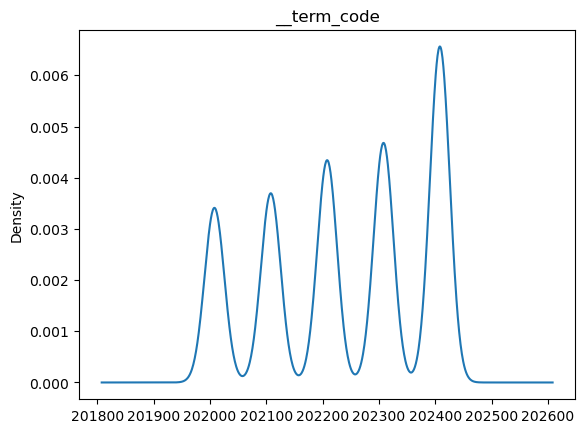

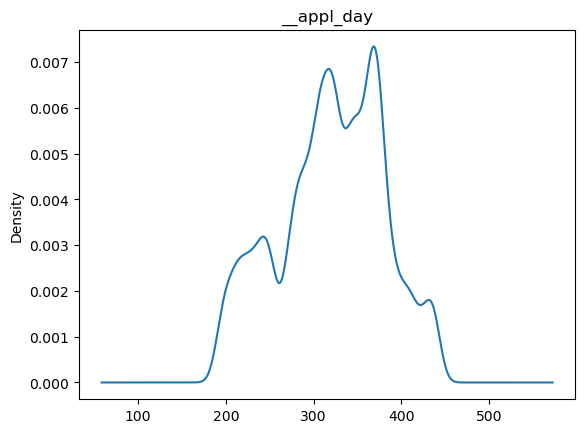

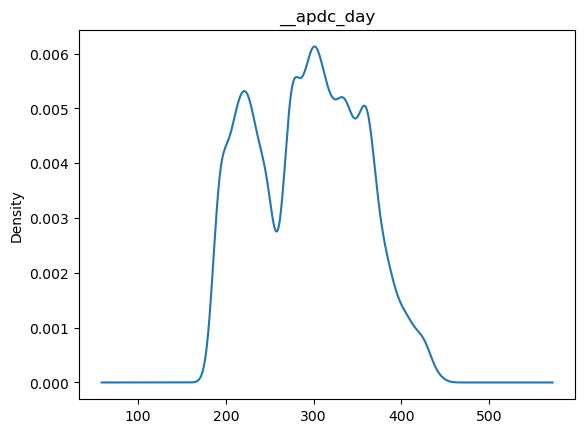

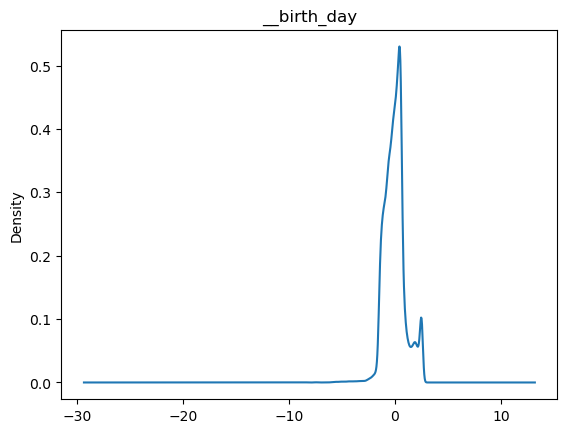

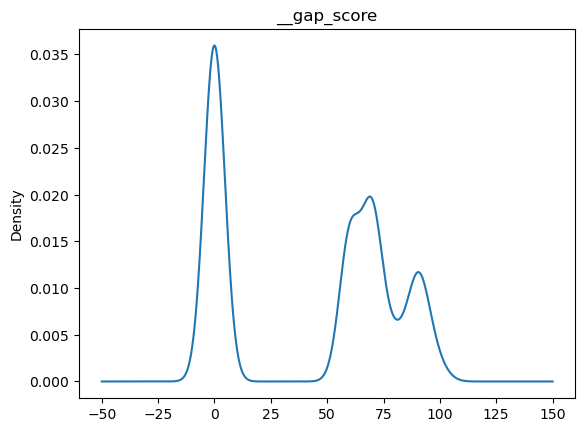

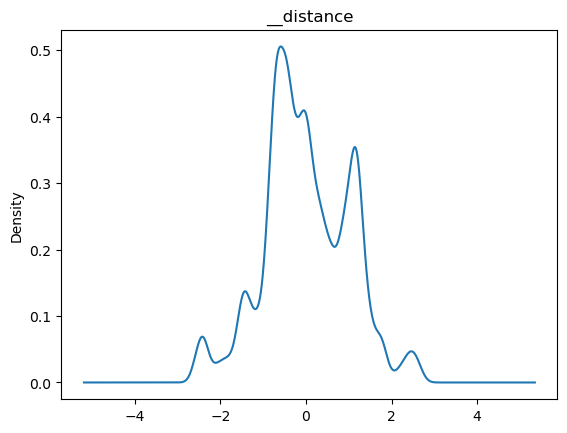

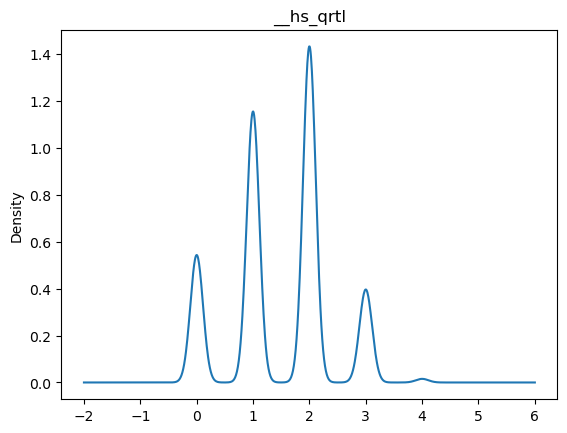

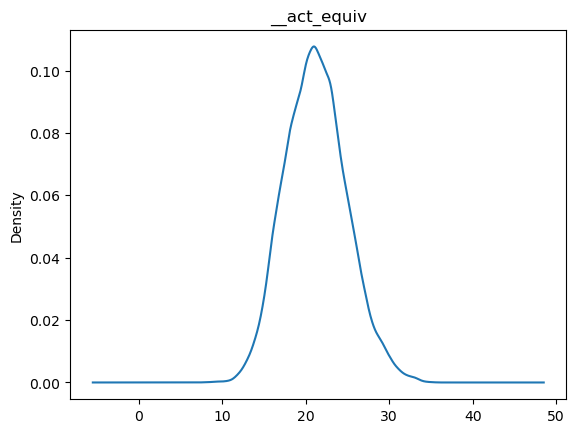

In [70]:
for k, v in self.X.select_dtypes('number').items():
    v.plot(kind='kde', title=k)
    plt.show()
    # print(k)

In [57]:
trf = PowerTransformer()
self.X['__birth_day'] = trf.fit_transform(self.X[['__birth_day']]).squeeze()
self.X['__birth_day'].describe()

count    3.472100e+04
mean     5.885100e-18
std      2.111926e-16
min     -1.165734e-15
25%     -1.110223e-16
50%     -5.551115e-17
75%      0.000000e+00
max      1.054712e-15
Name: __birth_day, dtype: float64

In [10]:
S[0].keys()
g = lambda Y: Y | {k: pd.concat([y[k] for y in Y.values() if k in y.keys()]).sort_index() for k in ['details','summary']}
g(S)
list(S.values())[0].keys()

dict_keys(['details', 'summary', 'model'])

In [26]:
def feature_importance_df(self, dataset=0, normalize=True, iteration=None):
    predictor_var_names = [self._get_variable_name(i) for i in sorted(self.predictor_vars)]
    imputed_var_names   = [self._get_variable_name(i) for i in sorted(self.imputation_order)]
    I = pd.DataFrame(self.get_feature_importance(dataset, iteration), index=imputed_var_names, columns=predictor_var_names).T
    return I / I.sum() * 100 if normalize else I
ImputationKernel.feature_importance_df = feature_importance_df
for k, v in self.pred.items():
    pass
m = v['_total'][202008]['n'][0]['model']
m.get_feature_importance(0)
feature_importance_df(m, 0).squeeze().sort_values()
#.keys()

__term_code                0.000000
__international            0.000000
__remote                   0.000000
__styp_code                0.000000
__gap_score                0.000000
_total_cur                 0.000000
__waiver                   0.000000
__coll_code                0.251889
__resd                     0.323858
__lgcy                     0.323858
__race_pacific             0.449802
__writing                  0.647715
__race_asian               0.863620
__race_american_indian     0.917596
__math                     0.971573
__reading                  1.241454
__race_black               1.259446
__ssb                      1.277438
__oriented                 1.889169
__schlship_app             2.374955
__race_hispanic            2.662828
__race_white               2.896725
__gender                   3.076646
__hs_qrtl                  3.976250
__act_equiv               11.155092
__distance                13.566031
__apdc_day                14.987406
__birth_day               15

In [ ]:
pip install
pip install git+https://github.com/AnotherSamWilson/miceforest.git


In [11]:
crse = '_total'
cols = uniquify(['_total_cur',crse+'_cur',crse])
X_imputed = list(self.imputed.values())[0]['n'][:1]
for k, X in enumerate(X_imputed):
    Z = X.join(self.Y[cols])
    Z.iloc[0,-1] = pd.NA
    imp = ImputationKernel(Z, train_nonmissing=True)
Z.disp(1)

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,__term_code,__appl_day,__apdc_day,__birth_day,__styp_code,__remote,__coll_code,__international,__race_american_indian,__race_asian,__race_black,__race_pacific,__race_white,__race_hispanic,__gender,__lgcy,__resd,__waiver,__schlship_app,__ssb,__math,__reading,__writing,__gap_score,__oriented,__distance,__hs_qrtl,__act_equiv,_total_cur,_total
pidm,term_code,term_desc,apdc_code,apdc_desc,levl_code,levl_desc,styp_code,styp_desc,admt_code,admt_desc,camp_code,camp_desc,coll_code,coll_desc,dept_code,dept_desc,majr_code,majr_desc,cnty_code,cnty_desc,stat_code,stat_desc,natn_code,natn_desc,resd_code,resd_desc,lgcy_code,lgcy_desc,international,gender,race_american_indian,race_asian,race_black,race_pacific,race_white,race_hispanic,waiver,birth_day,distance,hs_qrtl,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
88089,202008,fall 2020,r2,admitted (rp2),ug,undergraduate,n,new first time,ea,early admission (6th sem),s,stephenville,hl,health sciences,hhpf,health & human performance,kins,kinesiology,68,ector,tx,texas,<NA>,<NA>,r,texas resident,<NA>,<NA>,False,m,False,False,False,False,False,True,False,6695,16028.63,2,202008,307,281,6695,n,False,hl,False,False,False,False,False,False,True,m,True,True,False,True,True,False,False,False,0,n,16028.63,2,16.217822,0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
ImputationKernel?

Init signature:
ImputationKernel(
    data,
    datasets=5,
    variable_schema=None,
    imputation_order='ascending',
    train_nonmissing=False,
    mean_match_candidates=None,
    data_subset=None,
    mean_match_function=None,
    categorical_feature='auto',
    initialization='random',
    save_all_iterations=True,
    save_models=1,
    copy_data=True,
    random_state=None,
)
Docstring:     
Creates a kernel dataset. This dataset can:
    - Perform MICE on itself
    - Impute new data from models obtained from MICE.

Parameters
----------
data: np.ndarray or pandas DataFrame.
    The data to be imputed.

variable_schema: None or list or dict, default=None
    Specifies the feature - target relationships used to train models.
    This parameter also controls which models are built. Models can be built
    even if a variable contains no missing values, or is not being imputed
    (train_nonmissing must be set to True).

        - If None, all columns will be used as features in t

In [12]:
params_list[0]['imp'][0].__name__

'ImputationKernel'

In [ ]:
list(self.pred.values())[0]['rslt']['err_pct'].query("err_pct==' 50%'")

In [ ]:
crse = '_total'
styp_code = 'n'
clf = RandomForestClassifier()

for k, v in self.imputed.items():
    X_imputed = v[styp_code]
    S = dict()
    for k, X in enumerate(X_imputed):
        if params['imp'][0].__name__:
            

        Z = clone(enc).fit_transform(X).join(self.Y[cols])
        X = {'test': Z, 'train': Z.query(f"term_code==@train_term")}
        y = {k: x.pop(crse) for k, x in X.items()}
        model = clone(clf).fit(X['train'], y['train'])
        details = (
            y['test']
            .rename('true')
            .to_frame()
            .assign(pred=model.predict(X['test']), train_term=train_term, crse=crse, sim=k)
            .set_index(['train_term','crse','sim'], append=True)
            .binarize()
        )
        agg = lambda x: pd.Series({
            'pred': x['pred'].sum(min_count=1),
            'true': x['true'].sum(min_count=1),
            'mse_pct': ((1*x['pred'] - x['true'])**2).mean()*100,
            'f1_inv_pct': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
        })
        summary = details.groupby([*self.mlt_grp,'train_term','sim']).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
        for x in ['pred','true']:
            summary[x] = summary[x] * summary['mlt']
        summary.insert(2, 'err', summary['pred'] - summary['true'])
        summary.insert(3, 'err_pct', (summary['err'] / summary['true']).clip(-1, 1) * 100)


In [ ]:
a = dict()
a.setdefault('b',dict()).update({'c':4})
a

In [ ]:
ImputationKernel?

In [ ]:
p = {'imp':params_list[0]['imp']}
p
stringify = lambda P: str({f(step): [f(D[0]), {f(k): f(v) for k, v in D[1].items()}] for step, D in P.items()})
stringify(p)

In [ ]:
for k, v in self.pred.items():
    print(k)
    v['rslt']['err%'].query("err% == 0").disp(100)

In [ ]:
list(self.pred.values())[0]['rslt']['err%']

In [ ]:
# P = params_list[0]
# q = P['enc'].values()
# dict(q)
# dir(q)
# q.mapping()
list(P['enc'].values())

In [ ]:
params_list = cartesian({step: [[alg, values] for alg, grid in D.items() for values in cartesian(grid)] for step, D in params_grid.items()})
def f(x):
    try:
        return x.__name__
    except:
        return x
stringify = lambda P: {f(step): [f(k): f(v)  for k, v in D.items()} for step, D in P.items()}
# stringify(param_list[0])
P = params_list[0]
P

In [ ]:
param_list = cartesian({step: [{alg: values} for alg, grid in D.items() for values in cartesian(grid)] for step, D in params_grid.items()})
def f(x):
    try:
        return x.__name__
    except:
        return x
param_list[0]
stringify = lambda P: {f(step): {f(alg): {f(k): f(v) for k, v in H.items()} for alg, H in D.items()} for step, D in P.items()}
stringify(param_list[0])
    
# param_list
# S = [{f(step): {f(k): f(v)  for k, v in D.items()}  for step, D in P.items()} for P in param_list]
# S
# str(S[0])

In [ ]:
param_list = cartesian({step: [{'alg':alg}|values for alg, grid in D.items() for values in cartesian(grid)] for step, D in params_grid.items()})
def f(x):
    try:
        return x.__name__
    except:
        return x
stringify = lambda P: {f(step): {f(k): f(v)  for k, v in D.items()} for step, D in P.items()}
stringify(param_list[0])
    
# param_list
# S = [{f(step): {f(k): f(v)  for k, v in D.items()}  for step, D in P.items()} for P in param_list]
# S
# str(S[0])

In [ ]:
# from collections import Collection, Mapping

# def recursive_map(data, func):
#     apply = lambda x: recursive_map(x, func)
#     if isinstance(data, Mapping):
#         return type(data)({k: apply(v) for k, v in data.items()})
#     elif isinstance(data, Collection):
#         return type(data)(apply(v) for v in data)
#     else:
#         return func(data)
    
# def func(x):
#     try:
#         return x.__name__
#     except:
#         return x
    
# func(mean_match_kdtree_classification)
mean_match_kdtree_classification.__name__

In [ ]:
# tuple(sorted(params_list))
# str(params_list[0])
# params_list[0]
def f(x):
    try:
        return x.__name__
    except:
        return x

# [{f(k):v} for k,v in a.items() for a in params_list]

# {f(a): {f(b):} for a, A in }
# cartesian({step: [[alg, values] for alg, grid in D.items() for values in cartesian(grid)] for step, D in params_grid.items()})

In [ ]:
0x7f91603f5300

In [ ]:
step = 'clf'
G = cartesian({step: [{'alg':alg} | values for alg, grid in D.items() for values in cartesian(grid)] for step, D in param_grid.items()})
G = cartesian({step: [[alg, values] for alg, grid in D.items() for values in cartesian(grid)] for step, D in param_grid.items()})
len(G)
G[0]
# param_grid['clf']


# [{step: {'alg':alg} | values} for step, D in param_grid.items() for alg, grid in D.items() for values in cartesian(grid)][2]
# [(step, alg) for step, D in param_grid.items() for alg, grid in cartD.items() ]
# [{'alg':k} | m for k,v in param_grid['clf'].items() for m in cartesian(v)]

In [ ]:
list(param_grid['clf'].values())
# param_grid[0]['clf']

In [ ]:
def listify(X):
    if X is None or X is np.nan:
        return []
    elif isinstance(X, (str,int,float,bool)) or callable(X):
        return [X]
    else:
        return list(X)
listify(x)

In [ ]:
x = mean_match_kdtree_classification
print(type(x))
# list(x)
isinstance(x, type(sum))
type(sum)
x()

In [ ]:
def cartesian(dct):
    """Creates the Cartesian product of a dictionary with list-like values"""
    # try:
    D = {key: listify(val) for key, val in dct.items()}
    return [dict(zip(D.keys(), x)) for x in it.product(*D.values())]
    # except:
    #     return dict()


param_grid = {
    'enc': cartesian({
        'min_frequency': [0.1],
    }),
    'imp': cartesian({
        'datasets': [5],
        'save_all_iterations': [False],
        'mean_match_candidates': 10,
        'mean_match_function': mean_match_kdtree_classification,
    }),
    'clf':{
        RandomForestClassifier: {
            'max_depth': 3,
            'random_state': [1,2],
        },
        HistGradientBoostingClassifier: {
            'max_depth': 3,
            'random_state': [1,2],
        },
    }
}
param_grid['imp']

In [ ]:
from sklearn.base import clone, BaseEstimator
# p = {'alg':RandomForestClassifier, 'max_depth':3}
# p.pop('alg')(**p)
p = {
    RandomForestClassifier: {
        'max_depth': 3,
        'random_state': [1,2],
    },
    HistGradientBoostingClassifier(): {
        'max_depth': 3,
        'random_state': [1,2],
    }
}
a = [{'alg':k} | m for k,v in p.items() for m in cartesian(v)]
b = [{'alg':k} | m for k,v in p.items() for m in cartesian(v)]
c = a[0]
inst = lambda x: x if isinstance(x, BaseEstimator) else x()
inst(c.pop('alg')).set_params(**c)
# type(RandomForestClassifier)
# RandomForestClassifier.__mro__
# isinstance(RandomForestClassifier(), BaseEstimator)

In [ ]:
enc = ColumnTransformer([('cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)
enc.set_params(cat__min_frequency=0.5)

In [ ]:
self.X.dtypes

In [ ]:
from miceforest import ImputationKernel
from miceforest.mean_matching_functions import default_mean_match, mean_match_kdtree_classification
imp = ImputationKernel(self.X)
# kds.mice(1)

In [ ]:
imp.dataset_count()

In [ ]:
crse = '_total'
cols = uniquify(['_total_cur',crse+'_cur',crse])
self.Y[cols]

In [ ]:
X = kds.complete_data(0)
X.missing()
X.dtypes
enc = ColumnTransformer([('cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)
X = enc.fit_transform(X).join(self.Y[cols])
X = {'test': X, 'train': X.query(f"term_code==@train_term")}
y = {k: x.pop(crse) for k, x in X.items()}

# train_term = 202208
# X = {'test':X.copy(), 'train':X.query('term_code==@train_term')}
# y = {'test':self.Y.copy(), 'train':self.Y.query('term_code==@train_term')}
# clf = HistGradientBoostingClassifier()
# clf.fit(X['train'], y['train'])
# clf.predict(X['test'])


In [ ]:
# Z = enc.fit_transform(X).join(self.Y['cur'].rename(columns=lambda x:x+'_cur')).join(self.Y['end']>0).prep()
Y = self.Y['cur'].rename(columns=lambda x:x+'_cur').join(self.Y['end']>0).prep()

In [ ]:
df = list(self.pred.values())[0]['_total']['summary']

In [ ]:
self.Z['__act_equiv'].reset_index(drop=True).disp(200)

In [ ]:
from sklearn.linear_model import BayesianRidge, Ridge
est = Pipeline(verbose=False, steps=[
    ('prc', ColumnTransformer([('cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)),
    # ('imp', IterativeImputer(skip_complete=True, estimator=RandomForestRegressor())),
    ('imp', IterativeImputer(skip_complete=True, estimator=BayesianRidge())),
    
    # ('clf', HistGradientBoostingClassifier()),
    # ('clf', RandomForestClassifier()),
    # ('clf', GradientBoostingClassifier()),
])

self.X.missing().disp(100)
Q = est.fit_transform(self.X)
Q.missing().disp(100)

In [ ]:
{k:0 for k,v in est.get_params().items() if 'random_state' in k}

In [ ]:
a = list(self.pred.values())[0]['_total']
df = a['summary']
df.sort_index()

In [ ]:
'x'.ljust(5)

In [ ]:
df = list(self.pred.values())[0]['_total']['summary']
def pivot(df, val, q=50):
    Y = df.reset_index().pivot_table(columns='train_term', index=['crse','styp_code','pred_term'], values=val, aggfunc=[pctl(0),pctl(25),pctl(50),pctl(75),pctl(100),'max'])   # for _ in range(2):
    #     # mr = Y.mean(axis=1)
    #     ma = Y.abs().mean(axis=1)
    #     Y = (Y.assign(abs_mean=ma) if Y.shape[1] > 1 else Y).T
        # Y = (Y.assign(mean=mr, abs_mean=ma) if Y.shape[1] > 1 else Y).T
    return Y.stack(0)#.assign(**{val:f"{q}%"}).set_index(val, append=True).swaplevel(0,1).round(2).prep()


w = {stat: pivot(df.query(f"pred_term!={self.infer_term}"), stat) for stat in ["err","err%","mse%","f1_inv%"]}
w['err%'].sort_index()

# pivot(df.query(f"pred_term=={self.infer_term}"), "pred", q=25)

# list(self.pred.keys())[0]
# val = 'err%'
# q = 50
# df.query(f"pred_term!={self.infer_term}").reset_index().pivot_table(columns='train_term', index=['crse','pred_term','styp_code'], values=val, aggfunc=pctl(q))
# df.query(f"pred_term=={self.infer_term}").reset_index().pivot_table(columns='train_term', index=['crse','pred_term','styp_code'], values=val, aggfunc=pctl(q))
# pivot(df.query(f"pred_term!={self.infer_term}"), 'err%')
# {stat: pivot(df.query(f"pred_term!={self.infer_term}"), stat) for stat in ["err","err%","mse%","f1_inv%"]}
# pivot(df.query(f"pred_term=={self.infer_term}"), "pred")
# pd.concat([pivot(df.query(f"pred_term=={self.infer_term}"), "pred", q) for q in [25,50,75]], axis=1)
# for stat in ["err","err%","mse%","f1_inv%"]

In [ ]:
df = list(self.pred.values())[0]['_total']['summary']
df.disp(1000)

In [ ]:
def analyze(self):
    def pivot(df, val):
        Y = (
            df
            .reset_index()
            .pivot_table(columns='train_term', index=['crse','styp_code','pred_term'], values=val, aggfunc=[pctl(0),pctl(25),pctl(50),pctl(75),pctl(100)])
            .rename_axis(columns=[val,'train_term'])
            .stack(0)
            .assign(abs_mean = lambda x: x.abs().mean(axis=1))
        )
        return Y

    for k, v in self.pred.items():
        df = v['summary']
        mask = df.eval(f"pred_term!={self.infer_term}")
        v['rslt'] = {stat: pivot(df[mask], stat) for stat in ["pred","err","err%","mse%","f1_inv%"]} | {'pred': pivot(df[~mask], "pred")}
        # rslt['pred'] = pivot(df[~mask], "pred")
# rslt = {stat: pivot(df.query(f"pred_term!={self.infer_term}"), stat) for stat in ["pred","err","err%","mse%","f1_inv%"]}

# rslt['pred'] = pivot(df.query(f"pred_term=={self.infer_term}"), "pred")
rslt['pred']
rslt['err%']
# pivot(df.query(f"pred_term=={self.infer_term}"), "pred", q=25)

# list(self.pred.keys())[0]
# val = 'err%'
# q = 50
# df.query(f"pred_term!={self.infer_term}").reset_index().pivot_table(columns='train_term', index=['crse','pred_term','styp_code'], values=val, aggfunc=pctl(q))
# df.query(f"pred_term=={self.infer_term}").reset_index().pivot_table(columns='train_term', index=['crse','pred_term','styp_code'], values=val, aggfunc=pctl(q))
# pivot(df.query(f"pred_term!={self.infer_term}"), 'err%')
# {stat: pivot(df.query(f"pred_term!={self.infer_term}"), stat) for stat in ["err","err%","mse%","f1_inv%"]}
# pivot(df.query(f"pred_term=={self.infer_term}"), "pred")
# pd.concat([pivot(df.query(f"pred_term=={self.infer_term}"), "pred", q) for q in [25,50,75]], axis=1)
# for stat in ["err","err%","mse%","f1_inv%"]

In [ ]:
[(k,str(v)) for k,v in est.named_steps.items()]
# est.get_params()
# est['imp'].__repr__()
# est['imp'].

In [ ]:
def g(x):
    return 3
g.__name__ = 'hi'
g.__str__()

In [ ]:
est = Pipeline(verbose=False, steps=[
    # ('prc', ColumnTransformer([('cat', OneHotEncoder(), lambda X: X.apply(pd.api.types.is_string_dtype))], remainder='passthrough', verbose_feature_names_out=False)),
    ('prc', ColumnTransformer([('cat', OneHotEncoder(), lambda X: X.select_dtypes(['string','category']).columns)], remainder='passthrough', verbose_feature_names_out=False)),
    
    # ('imp', IterativeImputer()),
    # ('clf', HistGradientBoostingClassifier()),
])

p = cartesian(param_grid)[0]
est.set_params(**p).fit_transform(self.Z).disp(1)

In [ ]:
est.get_params()

In [ ]:
X.select_dtypes(['string','category']).columns

In [ ]:
x = np.nan
# x=None
x in [np.nan], x == np.nan, x is np.nan
np.fil

In [ ]:
p = cartesian(param_grid)[0]
est.set_params(**p)
P = est.get_params()
P2 = clone(est).get_params()
w = {k: (v,P2[k]) for k,v in P.items() if v!=P2[k]}
w.keys()
for k,v in w.items():
    print(k)
    print(type(v[0]))
    print(type(v[1]))
    print("-----------------------------------------")


In [ ]:
g = lambda X: X.apply(pd.api.types.is_string_dtype)
g(self.Z)

In [ ]:
est = Pipeline(verbose=False, steps=[
    ('prc', ColumnTransformer([('cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), lambda X: X.apply(pd.api.types.is_string_dtype))], remainder='passthrough', verbose_feature_names_out=False)),
    # ('prc', ColumnTransformer([('cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)),
    # ('imp', IterativeImputer()),
    # ('clf', HistGradientBoostingClassifier()),
])

e2 = clone(est)
P = est.get_params()
P2 = clone(est).get_params()
w = {k: (v,P2[k]) for k,v in P.items() if v!=P2[k]}
w.keys()
w['prc__cat']
# print(est['prc'].get_params())
# print(clone(est)['prc'].get_params())
# est.fit_transform(self.Z).disp(1)

In [ ]:
g = lambda x: pd.api.types.is_string_dtype(x)
g(self.Z['__styp_code'])

In [ ]:
cat = self.X.select_dtypes(['string','category']).columns.tolist()
est = Pipeline(verbose=False, steps=[
    ('prc', ColumnTransformer([('cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), cat)], remainder='passthrough', verbose_feature_names_out=False)),
    ('imp', IterativeImputer()),
    ('clf', HistGradientBoostingClassifier()),
])


In [ ]:
est.named_steps['enc'].__str__()
est.get_params()

In [ ]:
self.Y['end'].disp(1)

In [ ]:
model = est
model._params = tuple([('n_sims',3)] + sorted((k,v) for k,v in model.get_params(deep=True).items() if isinstance(v, (int,float,str,bool)) and v not in [None,np.nan]))
S = self.predict(est.set_params(enc__enc__min_frequency=0.1), '_total', 202208, 'n')
S[0].keys()

In [ ]:
A = list(self.pred.values())[0]#['_total'][202008]['n']
A.keys()
A['summary']
# A['summary']
# [202208]#['n']#.keys()#['summary']

In [ ]:
params = cartesian(param_grid)[0]
model = clone(est).set_params(**params)
P = tuple([('n_sims',3)] + sorted((k,v) for k,v in model.get_params(deep=True).items() if isinstance(v, (int,float,str,bool)) and v not in [None,np.nan]))
Q = list(self.pred.keys())[0]
len(P), len(Q)
for p,q in zip(P,Q):
    print(p==q,p,q)

In [ ]:
list(self.pred.keys())[0]

In [ ]:
est = Pipeline(verbose=False, steps=[
    ('enc', ColumnTransformer([('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'))], remainder='passthrough', verbose_feature_names_out=False)),
])


In [ ]:
est.fit(self.X, self.Y['end']['_total'])

In [ ]:
m.fit(x, y)

In [ ]:
# y.disp()
m.fit(x, y)

In [ ]:
list(self.pred.values())[0].keys()
# self.pred.keys()

In [ ]:
sorted([(1,2),(2,3), (1,2,3)])

In [ ]:
a = ColumnTransformer([('enc', OneHotEncoder)], remainder='passthrough', verbose_feature_names_out=False)
b = clone(a)
# a.get_params() == 
b.get_params
# dir(b)

In [ ]:
sorted((k,v) for k,v in est.get_params(deep=True).items() if isinstance(v, (int,float,str,bool)))

In [ ]:
est = Pipeline(verbose=False, steps=[
    ('enc', ColumnTransformer([('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'))], remainder='passthrough', verbose_feature_names_out=False)),
    ('imp', IterativeImputer(random_state=self.random_state)),
    ('clf', HistGradientBoostingClassifier(random_state=self.random_state)),
])
est._pa
# est2 = clone(est)
# eq = False
# P = est.get_params()
# Q = est2.get_params()
# N = [None,np.nan,pd.NA]

get_params = lambda est: {k:v for k,v in est.get_params(deep=True) if isinstance(v, (int,float,str,bool))}

# if P.keys() == Q.keys():
#     eq = all(v==Q[k] or pd.isnull([v,Q[k]]).all() for k,v in P.items() if isinstance(v, (int,float,str,bool,type,type(None))))
# eq
# d
    # for k, v in P.items():
    #     if isinstance(v, (int,float,str,bool,type,type(None))):

In [ ]:
v = pd.NA
isinstance(v, (int,float,str,bool,type,type(None),pd.NA))

In [ ]:
type(pd.NA)
np.isnan([1])
pd.isnull(pd.NA)

In [ ]:
pd.isnull([1,None]).all()

In [ ]:
est = Pipeline(verbose=False, steps=[
    ('enc', ColumnTransformer([('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'))], remainder='passthrough', verbose_feature_names_out=False)),
    ('imp', IterativeImputer(random_state=self.random_state)),
    ('clf', HistGradientBoostingClassifier(random_state=self.random_state)),
])
est.get_params(True)

In [ ]:
import pickle
from joblib import dump, load
import joblib 
from sklearn.base import clone
est = Pipeline(verbose=False, steps=[
    ('enc', ColumnTransformer([('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'))], remainder='passthrough', verbose_feature_names_out=False)),
    ('imp', IterativeImputer(random_state=self.random_state)),
    ('clf', HistGradientBoostingClassifier(random_state=self.random_state)),
])
est = Pipeline(verbose=False, steps=[
    ('enc', ColumnTransformer([('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'))], remainder='passthrough', verbose_feature_names_out=False)),
    ('imp', IterativeImputer(random_state=self.random_state)),
    ('clf', HistGradientBoostingClassifier(random_state=self.random_state)),
])

# s = pickle.dump(est)
# est2 = pickle.load(est)
f = '/home/scook/institutional_data_analytics/admitted_matriculation_projection/admitted_matriculation_predictor/src/temp.joblib'
s = joblib.dump(est, f)
est2 = joblib.load(f)
est == est2


# est2 = clone(est)
# est == est2
# # est2
N = est.named_steps
E = N['enc']
P = est.get_params(deep=True)
for k, v in P.items():
    if not isinstance(v, (int,float,str,bool,type,type(None))):
        print(k, type(v))
    # print(k, type(v), isinstance(v, (int,float,str,bool,type,type(None))))
# N2 = est2.named_steps
# N.keys() == N2.keys()
# for k in N.keys():
#     # print(k)
#     P = N[k].get_params()
#     P2 = N2[k].get_params()
#     print(P.keys() == P2.keys())
#     for l in P.keys():
#         if P[l] != P2[l]:
#             print(k, l)
#             print(P[l])
#             print(P2[l])

# #         print()
# #     print()
# # print(N['enc'].get_params())
# # print(N2['enc'].get_params())
# # est.get_params()
# # est.named_steps == est2.named_steps
# # est.

In [ ]:
from sklearn.compose import make_column_transformer
ColumnTransformer(transformers=[('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)
make_column_transformer((OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category'])), remainder='passthrough', verbose_feature_names_out=False)

In [ ]:
                # ('enc', ColumnTransformer([('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)),
                # ('imp', IterativeImputer(random_state=self.random_state)),
                # ('clf', HistGradientBoostingClassifier(random_state=self.random_state)),




from sklearn.preprocessing import OneHotEncoder, LabelEncoder
G = {
    'enc': {
        ColumnTransformer: {
            'tranformers':
        OneHotEncoder: {
            'sparse_output': False,
            'handle_unknown': 'infrequent_if_exist',
            'min_frequency': [0.1,0.2],
        },
        LabelEncoder: {
            'sparse_output': False,
            'handle_unknown': 'infrequent_if_exist',
            'min_frequency': [0.1,0.2],
        },
    },
    'imp': {
        IterativeImputer: {
            'initial_strategy': ['median','mean'],
        },
    }
    # __enc__min_frequency':[0.1],
    # # 'imp__initial_strategy': ['median'],
    # 'clf__learning_rate': [0.1,0.2],
    # 'n_sims': 4,
}
# cartesian({step: {meth: cartesian({name: listify(vals) for name, vals in M.items()}) for meth, M in S.items()} for step, S in G.items()})[0]
# {step: {meth: cartesian({name: listify(vals) for name, vals in M.items()}) for meth, M in S.items()} for step, S in G.items()}['enc']
# cartesian({step: {meth: {name: listify(vals) for name, vals in M.items()} for meth, M in S.items()} for step, S in G.items()})

# [{meth: values for values in cartesian(M)} for meth, M in G['enc'].items()]
step = 'enc'
# H = {step: [(method,values) for method, M in S.items() for values in cartesian(M) ] for step, S in G.items()}
H = {step: [[method,values] for method, M in S.items() for values in cartesian(M)] for step, S in G.items()}
q = cartesian(H)[0]

# meth = OneHotEncoder
# {meth: cartesian(G['enc'][meth])}

In [ ]:
                # ('enc', ColumnTransformer([('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)),
                # ('imp', IterativeImputer(random_state=self.random_state)),
                # ('clf', HistGradientBoostingClassifier(random_state=self.random_state)),

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
G = {
    'enc': {
        OneHotEncoder: {
            'sparse_output': False,
            'handle_unknown': 'infrequent_if_exist',
            'min_frequency': [0.1,0.2],
        },
        LabelEncoder: {
            'sparse_output': False,
            'handle_unknown': 'infrequent_if_exist',
            'min_frequency': [0.1,0.2],
        },
    },
    'imp': {
        IterativeImputer: {
            'initial_strategy': ['median','mean'],
        },
    }
    # __enc__min_frequency':[0.1],
    # # 'imp__initial_strategy': ['median'],
    # 'clf__learning_rate': [0.1,0.2],
    # 'n_sims': 4,
}
# cartesian({step: {meth: cartesian({name: listify(vals) for name, vals in M.items()}) for meth, M in S.items()} for step, S in G.items()})[0]
# {step: {meth: cartesian({name: listify(vals) for name, vals in M.items()}) for meth, M in S.items()} for step, S in G.items()}['enc']
# cartesian({step: {meth: {name: listify(vals) for name, vals in M.items()} for meth, M in S.items()} for step, S in G.items()})

# [{meth: values for values in cartesian(M)} for meth, M in G['enc'].items()]
step = 'enc'
# H = {step: [(method,values) for method, M in S.items() for values in cartesian(M) ] for step, S in G.items()}
H = {step: [[method,values] for method, M in S.items() for values in cartesian(M)] for step, S in G.items()}
q = cartesian(H)[0]

# meth = OneHotEncoder
# {meth: cartesian(G['enc'][meth])}

In [ ]:
self.pred['_total'][0]['summary']

In [ ]:
rslt = {'train': T} | {k: pd.concat([t[k] for t in T.values()]) for k in list(T.values()).pop().keys()}
# {k: 0 for k in list(T.values()).pop().keys()}
# T


# rslt = {'param':param, 'train': {train_term: self.predict(crse, param.copy(), train_term) for train_term in self.term_codes}}
# self.pred.setdefault(crse,list()).append(rslt)
rslt['summary']


In [ ]:
# d = {'a':3}
# # d[d.keys().pop()]
# d.keys().__iter__()[0]
v = list(d.values())[0]
v
# dir(v)

In [ ]:
crse = '_total'
w = self.pred[crse][0]
q = w['train']
q.

In [ ]:
crse = '_total'
W = self.pred[crse][0]
# for train_term, sims in W['train'].items():
#     for sim in sims:
#         for rslt, df in sim.items():
#             print(rslt)
# W |= {rslt: pd.concat([df for df in sim[rslt]])}

rslt = 'details'
L = [sim[rslt] for sims in W['train'].values() for sim in sims]

crse = '_total'
W = self.pred[crse][0]
W |= {rslt: pd.concat([sim[rslt] for sims in W['train'].values() for sim in sims]) for rslt in ['details','summary']}
W.keys()
    
    
    # df in sim[rslt]


        # print(sim.keys())
    # print(len(rslt))
    # print(rslt.keys())

In [ ]:
# iterations = 3

# opts = dict()
# opts['random_state'] = 42
# opts['save_all_iterations'] = False
# opts['datasets'] = 5
# opts['mean_match_candidates'] = 29
# opts['mean_match_function'] = mean_match_kdtree_classification

# opts['datasets'] = 2
# opts['mean_match_candidates'] = 1
# opts['mean_match_function'] = default_mean_match

# P = self.predict(opts=opts)

# R = self.train(iterations=iterations, opts=opts,
#     styp_codes='n',
#     # train_terms=202208,
#     )
# for k, v in R[False]['rslt'].items():
#     print(k)
#     v['err%'].disp(100)

# tune = []
# # for func in [mean_match_kdtree_classification, default_mean_match]:
#     # opts['mean_match_function'] = func
# for cand in range(2,41,3):
#     opts['mean_match_candidates'] = cand
#     print(mysort(opts))
#     R = self.train(
#         styp_codes='n',
#         iterations=iterations,
#         opts=opts)
#     R[False]['rslt']['_total','n']['err%'].disp(100)
#     tune.append(R)
#     write(self.tune, tune)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

seed = 0
n_sims = 2
param_grid = cartesian({
    'enc__enc__min_frequency':[0.05,0.1],
    'imp__initial_strategy': ['median'],
    'clf__learning_rate': [0.1],
})

rslt = dict()
# for crse, param, train_term in it.product(self.crse, param_grid, self.term_codes):
for crse in self.crse:
    for param in param_grid:
        for train_term in self.term_codes:
    print(crse, train_term, param)
    rslt.setdefault(crse, list()).append({'param':param, 'train':dict()})
    cols = uniquify([*self.feat,'_total_cur',crse+'_cur',crse])
    X = self.Z[cols]
    X = {'test': X, 'train': X.query(f"term_code==@train_term")}
    y = {k: x.pop(crse) for k, x in X.items()}
    for sim in range(n_sims):
        est = Pipeline(verbose=False, steps=[
            ('enc', ColumnTransformer([('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category']))], remainder='passthrough', verbose_feature_names_out=False)),
            ('imp', IterativeImputer(random_state=seed)),
            ('clf', HistGradientBoostingClassifier(random_state=seed)),
        ]).set_params(**param).fit(X['train'], y['train'])
        details = (
            y['test']
            .rename('true')
            .to_frame()
            .assign(pred=est.predict(X['test']), train_term=train_term, crse=crse, sim=sim)
            .set_index(['train_term','crse','sim'], append=True)
            .binarize()
        )
        agg = lambda x: pd.Series({
            'pred': x['pred'].sum(min_count=1),
            'true': x['true'].sum(min_count=1),
            'mse%': ((1*x['pred'] - x['true'])**2).mean()*100,
            'f1_inv%': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
        })
        summary = details.groupby([*self.mlt_grp,'train_term','sim']).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
        for x in ['pred','true']:
            summary[x] = summary[x] * summary['mlt']
        summary.insert(2, 'err', summary['pred'] - summary['true'])
        summary.insert(3, 'err%', (summary['err'] / summary['true']).clip(-1, 1) * 100)
        rslt[crse][-1]['train'].setdefault(train_term, list()).append({'details':details, 'summary':summary})
        # assert 1==2

    # rslt[crse][-1]['train'].setdefault(train_term, list()).append({'details':, 'summary':  })

In [ ]:
# summary.disp(1)
r = rslt['_total'][0]
r['param']
r['train'][202008][0].keys()

In [ ]:
def cartesian(dct):
    """Creates the Cartesian product of a dictionary with list-like values"""
    D = {key: listify(val) for key, val in dct.items()}
    return [dict(zip(D.keys(), x)) for x in it.product(*D.values())]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

seed = 0
train_term = 202208
crse = '_total'
cols = list({'_total',crse})

for sim in range(1):
    X = (
        self.X
        .join(self.Y['cur'][cols].rename(columns=lambda x:x+'_cur'))
        .join(self.Y['end'][crse]>0)
        .assign(train_term=train_term, crse=crse, sim=sim)
        .prep()
        .set_index(['train_term','crse','sim'], append=True)
    )
    X = {'test': X.copy(), 'train': X.query(f"term_code==@train_term")}
    y = {k: x.pop(crse) for k, x in X.items()}

    enc = ColumnTransformer(remainder='passthrough', verbose_feature_names_out=False, transformers=[
        ('enc', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['string','category'])),
    ])

    est = Pipeline(verbose=False, steps=[
        ('enc', enc),
        ('imp', IterativeImputer(random_state=seed)),
        ('clf', HistGradientBoostingClassifier(random_state=seed)),
    ])
    param_grid = {
        'enc__enc__min_frequency':[0.05],
        'imp__initial_strategy': ['median'],
        'clf__learning_rate': [0.2],
    }
    grid = GridSearchCV(estimator=est, param_grid=param_grid)
    grid.fit(X['train'], y['train'])
    model = grid.best_estimator_


In [ ]:
P = y['test'].rename('true').to_frame().assign(pred=model.predict(X['test'])).binarize()
P.disp(1)
agg = lambda x: pd.Series({
    'pred': x['pred'].sum(min_count=1),
    'true': x['true'].sum(min_count=1),
    'mse%': ((1*x['pred'] - x['true'])**2).mean()*100,
    'f1_inv%': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
})
S = P.groupby([*self.mlt_grp,'train_term','sim']).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
for x in ['pred','true']:
    S[x] = S[x] * S['mlt']
# # # S.insert(2, 'err', S['pred'] - S['true'])
# # # S.insert(3, 'err%', (S['err'] / S['true']).clip(-1, 1) * 100)
S

In [ ]:
# print(check_params_exist(pipe, 'imputer'))
model.get_params().keys()

In [ ]:
e = pipe['enc']
vars(e)
# e.onehotencoder
e.named_transformers_['onehotencoder']
e.transformers_[0]
# e.onehotencoder

In [ ]:
pipe.fit_transform(X['train']).disp(1)

pick imp & clf hyperparams
imp m datasets
draw n shuffled datasets
train on one year
predict on others
apply multiplier
compute error

In [ ]:
self.X.query('idx==0')

In [ ]:
crse = '_total'
train_term = 202208

iterations = 3
opts = dict()
opts['random_state'] = 42
opts['save_all_iterations'] = False
opts['datasets'] = 2
opts['mean_match_candidates'] = 29
cols = list({'_total',crse})

imp = ImputationKernel(self.X, **opts)
imp.mice(iterations)
self.Z = (
    pd.concat([imp.complete_data(k).assign(sim=k) for k in range(imp.dataset_count())])
    .pipe(pd.get_dummies)
    .join(self.Y['cur'][cols].rename(columns=lambda x:x+'_cur'))
    .join(self.Y['end'][crse]>0)
    .prep()
)

In [ ]:
self.Z.query('"index"==17404')

# .query('pidm==2710').disp(1000)#.query('index==0')#.shape#.sort_index().disp(10)
# self.Z.groupby('pidm').size()

In [ ]:
self.Z = (
    pd.concat([
        imp.complete_data(k)
        .assign(sim=k)
        
    for k in range(imp.dataset_count())])
    .pipe(pd.get_dummies)
    .join(self.Y['cur'][cols].rename(columns=lambda x:x+'_cur'))
    .join(self.Y['end'][crse]>0)
    .prep()
)

In [ ]:
# self.Z.groupby(self.attr).ngroup().sort_index().disp(10)
# self.Z.groupby('index')
self.X = self.X.reset_index().reset_index().set_index(['index',*self.attr])

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

In [ ]:
self.X

In [ ]:
self.Z

In [ ]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
train_term = 202208
# Z = self.Z.reset_index().sample(frac=1).drop_duplicates(self.attr).assign(train_term=train_term, crse=crse).set_index([*self.attr,'train_term','crse','sim'])
Z = (
    self.Z
    .sample(frac=1)
    .reset_index()
    .drop_duplicates(self.attr)
    .assign(train_term=train_term, crse=crse)
    .set_index([*self.attr,'train_term','crse','sim'])
)
X = {'test':Z, 'train':Z.query(f'term_code=={train_term}')}
y = {k: v.pop(crse) for k, v in X.items()}
clf = HistGradientBoostingClassifier()
clf.fit(X['train'], y['train'])
P = y['test'].rename('true').to_frame().assign(pred=clf.predict(X['test'])).binarize()

agg = lambda x: pd.Series({
    'pred': x['pred'].sum(min_count=1),
    'true': x['true'].sum(min_count=1),
    'mse%': ((1*x['pred'] - x['true'])**2).mean()*100,
    'f1_inv%': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
})
S = P.groupby([*self.mlt_grp,'train_term']).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
for x in ['pred','true']:
    S[x] = S[x] * S['mlt']
# S.insert(2, 'err', S['pred'] - S['true'])
# S.insert(3, 'err%', (S['err'] / S['true']).clip(-1, 1) * 100)
S

# P.groupby([*self.mlt_grp,'train_term','crse','sim']).sum()

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
agg = lambda y: where(y).groupby(self.mlt_grp)['credit_hr'].agg(lambda x: (x>0).sum())
A = agg(self.reg_df['end'])
self.Y = {k: self.X[[]].join(y.set_index(['pidm','term_code','crse'])['credit_hr']) for k, y in self.reg_df.items()}
B = agg(self.Y['end'])
M = (A / B).replace(np.inf, pd.NA).rename('mlt').reset_index().query(f"term_code != {self.infer_term}").prep()
N = M.assign(term_code=self.infer_term)
self.mlt = pd.concat([M, N], axis=0).set_index(self.mlt_grp)
# self.Y = Y
self.Y = {k: y.squeeze().unstack().dropna(how='all', axis=1).fillna(0) for k, y in self.Y.items()}
self.Y['end'].disp(1)

In [ ]:
# self.Y = {k: y.squeeze().unstack().dropna(how='all', axis=1).fillna(0) for k, y in Y.items()}
self.Y['end'].groupby(self.mlt_grp).agg(lambda x:(x>0).sum())

In [ ]:
self.mlt

In [ ]:
self.mlt_grp = ['levl_code', 'styp_code', 'term_code','crse']

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
with warnings.catch_warnings(action='ignore'):
    Y = {k: pd.concat([term.reg[k].query("crse in @self.crse") for term in self.term.values()]) for k in ['cur','end']}
agg = lambda y: where(y).groupby(self.mlt_grp)['credit_hr'].agg(lambda x: (x>0).sum())
A = agg(Y['end'])
# A.disp(10)
Y = {k: self.X[[]].join(y.set_index(['pidm','term_code','crse'])['credit_hr']) for k, y in Y.items()}
B = agg(Y['end'])
M = (A / B).replace(np.inf, pd.NA).rename('mlt').reset_index().query(f"term_code != {self.infer_term}").prep()
N = M.assign(term_code=self.infer_term)
self.mlt = pd.concat([M, N], axis=0).set_index(self.mlt_grp)
self.Y = {k: y.squeeze().unstack().dropna(how='all', axis=1).fillna(0) for k, y in Y.items()}

fat = lambda y: y.squeeze().unstack('crse').dropna(how='all', axis=1).fillna(0)
# fat(self.mlt)
self.mlt.squeeze()#unstack('crse')

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
with warnings.catch_warnings(action='ignore'):
    Y = {k: pd.concat([term.reg[k].query("crse in @self.crse") for term in self.term.values()]) for k in ['cur','end']}
agg = lambda y: where(y).groupby(self.mlt_grp)['credit_hr'].agg(lambda x: (x>0).sum())
A = agg(Y['end'])
# A.disp(10)
Y = {k: self.X[[]].join(y.set_index(['pidm','term_code','crse'])['credit_hr']) for k, y in Y.items()}
B = agg(Y['end'])
M = (A / B).replace(np.inf, pd.NA).rename('mlt').reset_index().query(f"term_code != {self.infer_term}").prep()
N = M.assign(term_code=self.infer_term)
self.mlt = pd.concat([M, N], axis=0).set_index(self.mlt_grp)
self.mlt

# self.Y = Y
# fat = lambda y: y.squeeze().unstack('crse').dropna(how='all', axis=1).fillna(0)
# self.Y = {k: fat(y) for k, y in Y.items()}
# self.mlt
# fat(self.mlt)
# self.Y = {k: y.squeeze().unstack('crse').dropna(how='all', axis=1).fillna(0) for k, y in Y.items()}
# self.Y['end'].disp(1)


In [ ]:
w = self.mlt_grp
w.pop(0)
w

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()

with warnings.catch_warnings(action='ignore'):
    Y = {k:
         pd.concat([term.reg[k].query("crse in @self.crse") for term in self.term.values()])
         .set_index(['pidm',*w,'crse'])['credit_hr'].unstack()
          
          
           for k in ['cur','end']}
agg = lambda y: where(y).groupby(w).agg(lambda x: (x>0).sum()).prep()
A = agg(Y['end'])
# A.disp(100)
Y = {k: self.X[[]].join(y.droplevel(['levl_code','styp_code'])) for k, y in Y.items()}
# B = agg(Y['end'])
# M = (A / B).replace(np.inf, pd.NA).rename('mlt').reset_index().query(f"term_code != {self.infer_term}").prep()

# N = M.assign(term_code=self.infer_term)
# self.mlt = pd.concat([M, N], axis=0).set_index(self.mlt_grp)
# self.Y = {k: y.squeeze().unstack().dropna(how='all', axis=1).fillna(0) for k, y in Y.items()}
Y['end'].droplevel('levl_code')

# Z = (
#     self.X
#     .pipe(pd.get_dummies)
#     .join(self.Y['cur'][cols].rename(columns=lambda x:x+'_cur'))
#     .join(self.Y['end'][crse]>0)
#     .prep()
# )

In [ ]:
self.Y['cur'].keys()

In [ ]:
(self.Z.query('sim==0')[crse]>0).groupby(['styp_code','term_code']).sum()
1777*1.27

In [ ]:
self.Z.query('sim==0')[crse].groupby(['styp_code','term_code']).sum()

In [ ]:
(self.Y['end']>0).groupby(w).sum()

In [ ]:
w = self.mlt_grp
w.pop(0)
w

In [ ]:
self.Z['_total'].groupby(w).sum()

In [ ]:
self.mlt

In [ ]:
crse = '_total'
Q = (self.Y['end'][[crse]]>0).assign(crse=crse).groupby(self.mlt_grp).sum().join(self.mlt)
Q[crse] *= Q['mlt']
Q

In [ ]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
train_term = 202208
# Z = self.Z.reset_index().sample(frac=1).drop_duplicates(self.attr).assign(train_term=train_term, crse=crse).set_index([*self.attr,'train_term','crse','sim'])
Z = (
    self.Z
    .sample(frac=1)
    .reset_index()
    .drop_duplicates(self.attr)
    .assign(train_term=train_term, crse=crse)
    .set_index([*self.attr,'train_term','crse','sim'])
)
X = {'train': Z.query(f'term_code=={train_term}'), 'test': Z}
y = {k: v.pop(crse) for k, v in X.items()}
clf = HistGradientBoostingClassifier()
clf.fit(X['train'], y['train'])
P = y['test'].rename('true').to_frame().assign(pred=clf.predict(X['test'])).binarize()

agg = lambda x: pd.Series({
    'pred': x['pred'].sum(min_count=1),
    'true': x['true'].sum(min_count=1),
    'mse%': ((1*x['pred'] - x['true'])**2).mean()*100,
    'f1_inv%': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
})
S = P.groupby([*self.mlt_grp,'train_term']).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
for x in ['pred','true']:
    S[x] = S[x] * S['mlt']
# S.insert(2, 'err', S['pred'] - S['true'])
# S.insert(3, 'err%', (S['err'] / S['true']).clip(-1, 1) * 100)
S

# P.groupby([*self.mlt_grp,'train_term','crse','sim']).sum()

In [ ]:
P.disp(1)

In [ ]:
self.term[202208].reg['cur'].empty

In [ ]:
from LiveAMP import *
attr = [
        'term_code',
        'pidm',
        'hs_qrtl',
    ]
feat= [
        'term_code',
        ['birth_day','median',['term_code','styp_code']],
        ['international',False],
]

def f(A):
    A = [listify(x) for x in A]
    return {x.pop(0): x if x else [np.nan] for x in A}
L = [f(attr), f(feat)]
cols = L[0] | L[1]
attr, feat = [list(x.keys()) for x in L]

# attr = f(attr)
# feat = f(feat)
# cols = attr | feat
# attr = list(attr.keys())
# feat = list(feat.keys())

# attr
# c0

# for A in [attr, feat]:
#     A = [listify(x) for x in A]
#     cols |= {x.pop(0): x if x else [np.nan] for x in A}
#     A = list(A.keys())

# attr = [listify(x) for x in attr]
# feat = [listify(x) for x in feat]
# feat = {x.pop(0): x if x else [np.nan] for x in feat}
# attr = {x.pop(0): x if x else [np.nan] for x in attr}
# cols = attr | feat
# attr = list(attr.keys())
# feat = list(feat.keys())
# # cols = {x.pop(0): x if x else [np.nan] for x in attr+feat}
# # print(cols)
# where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
# X = where(self.X)
# for k, v in cols.items():
#     X[k] = X.impute(k, *v)
# X.missing()
# X = X.prep().binarize().categorize().set_index(attr, drop=False)[feat].rename(columns=lambda col:'_'+col)
# X
cols
attr
# feat

In [ ]:
attr = {x: [np.nan] for x in self.attr}
feat = {x[0][1:]:listify(x[1]) for x in self.feat}
cols = attr | feat
# cols = {k:listify(v) for k,v in cols.items()}
cols
# where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
# X = where(self.X)
# X.missing().disp(1000)
# cols
# for k, v in cols.items():
#     X[k] = X.impute(k, *listify(v))
# X = X.prep().binarize().categorize()
# X.missing().disp(1000)
# Z = pd.concat([X.impute(*x) for x in self.feat], axis=1).prep().binarize().categorize()

# col = uniquify(self.attr + feat)



# .set_index(self.attr, drop=False).rename(columns=lambda col:'_'+col)
# # X = where(self.X).reset_index().set_index(self.attr, drop=False).rename(columns=lambda col:'_'+col)
# self.Z = pd.concat([X.impute(*x) for x in self.feat], axis=1).prep().binarize().categorize()


In [ ]:
self.Y['cur'].shape

In [ ]:
self.X

In [ ]:
P = y['test'].rename('true').to_frame().assign(train_term=train_term, crse=crse, pred=clf.predict(X['test'])).binarize()
P.groupby([*self.mlt_grp,'train_term','crse']).sum()

In [ ]:
X['train'].disp(1)

In [ ]:
self.Z.shape, Z.shape

In [ ]:
pd.concat([imp.complete_data(k).assign(sim=k) for k in range(imp.dataset_count())]).transform(pd.get_dummies).disp(1)

In [ ]:
self.Y['cur'].disp(1)

In [ ]:
Z = (
    pd.concat([imp.complete_data(k).assign(sim=k) for k in range(imp.dataset_count())])
    .pipe(pd.get_dummies)
    .join(self.Y['cur'][cols].rename(columns=lambda x:x+'_cur'))
    .join(self.Y['end'][crse])
    .reset_index()
    .sample(frac=1)
    .drop_duplicates(self.attr)
    .set_index([*self.attr,'sim'])
)
Z
# pd.get_dummies(Z)

# X = Z.reset_index().sample(frac=1).drop_duplicates(self.attr).set_index([*self.attr,'sim'])
# train_term = 202208
# qry = {'infer': f'term_code=={self.infer_term}', 'train': f'term_code=={train_term}'}
# qry['test'] = f"~({join(qry.values(),'|')})"
# X = {k: X.query(v) for k, v in qry.items()}
# X = {'train': Z.query(f'term_code=={train_term}'), 'test': Z.query(f'term_code!={train_term}')}



# X['test'].vc('term_code')
# X = {"infer":X.query(f"term_code=={self.infer_term}"), "train"}

# Z#.index#['index']
# Z.loc['pidm']
# Z.index.names
# Z.groupby('index').size()
# Z = Z.sample(frac=1)
# Z
# Z.reset_index?

# ('index', drop=False)#.drop_duplicates('index')#.vc('sim')
# sample(n=1)


In [ ]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
qry = {"infer": f"term_code=={self.infer_term}", "train": f"term_code==train_term"}
qry['test'] = "~("+join(qry.values() ,' | ')+")"
X = dict()
y = dict()
for k, v in qry.items():
    X[k] = Z.query(v)
    y[k] = X[k].pop(crse)
# clf = RandomForestClassifier(categorical_features=self.Z.select_dtypes('category').columns.tolist())
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier()#categorical_features=X['train'].select_dtypes('category').columns.tolist())
# clf.categorical_features
# X['train'].dtypes
clf.fit(X['train'], y['train'])
y['pred'] = clf.predict(X['test'])


In [ ]:
y['pred'] = clf.predict(X['test']).astype('boolean')

In [ ]:
details = y['test'].rename('true').to_frame().assign(pred=y['pred']).binarize().assign(crse=crse)
details.groupby([*self.mlt_grp,'train_term','sim']).sum()


In [ ]:
pd.get_dummies(Z).columns

In [ ]:
self.Z.query('coll_code==00')

In [ ]:
print(Z.columns)
W = pd.get_dummies(self.Z)
print(W.columns)
W[W['_coll_code_00']].disp(2)

In [ ]:
Z = pd.concat([imp.complete_data(k).join(self.Y['end'][crse]>0).assign(train_term=train_term, sim=k).set_index(['train_term','sim'], append=True) for k in range(imp.dataset_count())])

In [ ]:
self.Z.select_dtypes('category').columns.tolist()
# pd.api.types.is_string_dtype(x) for x in self.Z)
# A = self.Z.dtypes.to_frame()
# A.query("0=='index")
# A[A=='category']

In [ ]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
qry = {"infer": f"term_code=={self.infer_term}", "train": f"term_code==train_term"}
qry['test'] = "~("+join(qry.values() ,' | ')+")"
X = dict()
y = dict()
Z = pd.get_dummies(Z)
for k, v in qry.items():
    X[k] = pd.get_dummies(Z).query(v)
    y[k] = X[k].pop(crse)
# clf = RandomForestClassifier(categorical_features=self.Z.select_dtypes('category').columns.tolist())
clf = HistGradientBoostingClassifier()#categorical_features=X['train'].select_dtypes('category').columns.tolist())
# clf.categorical_features
# X['train'].dtypes
clf.fit(X['train'], y['train'])
# y['pred'] = clf.predict(X['test'])


In [ ]:
X['infer'].vc('term_code')

In [ ]:
I[0].join(self.Y['end'][crse]>0)

In [ ]:
self = P['model']
predictor_var_names = [self._get_variable_name(i) for i in np.sort(self.predictor_vars)]
imputed_var_names   = [self._get_variable_name(i) for i in self.imputation_order]
I = pd.DataFrame(self.get_feature_importance(0), index=imputed_var_names, columns=predictor_var_names).T
I


In [ ]:
self.Z.missing()

In [ ]:
model = P['model']
# [model._get_variable_name(i) for i in model.imputation_order]
# model.imputation_order
# [model._get_variable_name(int(i)) for i in np.sort(model.imputation_order)]
model.vars_with_any_missing
self.Z.columns[27]

In [ ]:
k = 0
model = self.pred[k]['model']
# [model._get_variable_name(int(i)) for i in np.sort(model.imputation_order)]
# model.imputed_variable_count
# model.column_names
# print(self.pred[k]['meta'])
model.feature_importance_df().sort_values('_total_end', ascending=False)

In [ ]:
self.Z.shape
self.term[202208].adm['zip']

In [ ]:
ImputationKernel?

In [ ]:
self.X.binarize()['international'].dtype
self.X['international'].dropna().dtype

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
X = where(self.X.binarize()).set_index(self.attr, drop=False).rename(columns=lambda col:'_'+col)
# X['_international'].disp(1)
X.impute('_international', False)
# X.dtypes.disp(1000)
# self.X.dtypes.disp(100)
# pd.concat([X.impute(*x) for x in self.feat], axis=1).prep().binarize().categorize()
# X.columns

In [ ]:
def binarize(ser):
    assert isinstance(ser, pd.Series)
    s = set(ser.dropna())
    if s:
        try:
            ser = ser.str.lower()
            if s.issubset({'y','n'}):
                ser = (ser=='y').astype('boolean').fillna(False)
            if s.issubset({'true','false'}):
                ser = (ser=='true').astype('boolean').fillna(False)
        except:
            if s.issubset({0,1}):
                ser = ser.astype('boolean').fillna(False)
    return ser
A = R['international'].str.lower()
(A=='true').astype('boolean').fillna(False)
# binarize(A).sum()

In [ ]:
# self.term[202408].adm['international'].dtypes
# self.reg
R = pd.concat([term.raw for term in self.term.values()], ignore_index=True).dropna(axis=1, how='all').prep()
R['international'].value_counts()#.dtype

In [ ]:
self.term[202208].adm['international'].dropna()

In [ ]:
R['international'].dropna()

In [ ]:
self.X.columns
self.X['international'].value_counts()
# self.X['natn_code'].value_counts()

In [ ]:
qry = f"""select distinct B.gorvisa_natn_code_issue, B.gorvisa_vtyp_code from gorvisa B"""
db.execute(qry).disp(1000)

In [ ]:
from LiveAMP import *
t = TERM(term_code=202008, overwrite={'adm':True}, show={'adm':True})
A = t.get_adm()

In [ ]:
A['zip']

In [ ]:
db.head('gorvisa')
# db.value_counts('gorvisa','gorvisa_natn_code_issue','gorvisa_pidm')
# qry = "select * from (select gorvisa_pidm, count(gorvisa_natn_code_issue) as ct from gorvisa group by gorvisa_pidm) where ct>1"
# qry = "select gorvisa_pidm, count(distinct gorvisa_natn_code_issue) as ct from gorvisa group by gorvisa_pidm order by ct desc"
# db.head(qry)

In [ ]:
qry = f"""
select A.* from (
    select 
        A.*,
        case
            when max(case when A.cycle_day >= 0 then A.cycle_date end) over (partition by A.pidm, A.appl_no) = A.cycle_date then 1
            end as r1,
        case
            when sum(case when A.cycle_day <  0 then 1 end) over (partition by A.pidm, A.appl_no) >= 0/2 then 1
            when sysdate - trunc(to_date('11-Sep-20')) < 5 then 1
            end as r2
    from (
        select 
            trunc(to_date('11-Sep-20')) - trunc(A.current_date) as cycle_day,
            trunc(A.current_date) as cycle_date,
            min(trunc(A.current_date)) over (partition by A.pidm, A.appl_no) as appl_date,
            min(case when A.apst_code = 'D' and A.apdc_code in (select stvapdc_code from stvapdc where stvapdc_inst_acc_ind is not null) then trunc(A.current_date) end) over (partition by A.pidm, A.appl_no) as apdc_date,
            A.pidm,
            A.id,
            A.term_code as term_code_entry,
            A.levl_code,
            A.styp_code,
            A.admt_code,
            A.appl_no,
            A.apst_code,
            A.apdc_code,
            A.camp_code,
            A.saradap_resd_code as resd_code,
            A.coll_code_1 as coll_code,
            A.majr_code_1 as majr_code,
            A.dept_code,
            A.hs_percentile as hs_pctl
        from opeir.admissions_fall2020 A
    ) A where cycle_day between 0 and 0 + 14 and A.apst_code = 'D' and A.apdc_code in (select stvapdc_code from stvapdc where stvapdc_inst_acc_ind is not null)
) A where A.r1 = 1 and A.r2 = 1
"""
db.head(qry)

In [ ]:
qry = f"""
select A.* from (
--select A.r2, count(*) from (
    select 
        A.*,
        case
            when max(case when A.cycle_day >= 0 then A.cycle_date end) over (partition by A.pidm, A.appl_no) = A.cycle_date then 1
            end as r1,
        case
            when sum(case when A.cycle_day <  0 then 1 else 0 end) over (partition by A.pidm, A.appl_no) >= 0/2 then 1
            when sysdate - trunc(to_date('11-Sep-23')) < 5 then 1
            end as r2
    from (
        select 
            trunc(to_date('11-Sep-23')) - trunc(A.current_date) as cycle_day,
            trunc(A.current_date) as cycle_date,
            min(trunc(A.current_date)) over (partition by A.pidm, A.appl_no) as appl_date,
            min(case when A.apst_code = 'D' and A.apdc_code in (select stvapdc_code from stvapdc where stvapdc_inst_acc_ind is not null) then trunc(A.current_date) end) over (partition by A.pidm, A.appl_no) as apdc_date,
            A.pidm,
            A.id,
            A.term_code as term_code_entry,
            A.levl_code,
            A.styp_code,
            A.admt_code,
            A.appl_no,
            A.apst_code,
            A.apdc_code,
            A.camp_code,
            A.saradap_resd_code as resd_code,
            A.coll_code_1 as coll_code,
            A.majr_code_1 as majr_code,
            A.dept_code,
            A.hs_percentile as hs_pctl
        from opeir.admissions_fall2023 A
    ) A where cycle_day between 0 and 0 + 14 and A.apst_code = 'D' and A.apdc_code in (select stvapdc_code from stvapdc where stvapdc_inst_acc_ind is not null)
) A where A.r1 = 1 and A.r2 = 1
"""
A = db.head(qry)
A

In [ ]:
A.query('r1.notnull()')

In [ ]:
model = self.pred[-1]['model']
model.mean_match_function

In [ ]:
self.pred[0]['summary']

In [ ]:
R[False]['summary'].disp(200)

In [ ]:
for g, d in R[False]['rslt'].items():
    print(g)
    d['err%'].disp(100)
    # print(df.keys())

In [ ]:
for k in R[False]['rslt'].keys():
    for b, v in R.items():
        print(k, b)
        v['rslt'][k]['err%'].disp(100)


In [ ]:
R = self.train(iterations=iterations, opts=opts,
    styp_codes='n',
    # train_terms=202208,
    )

def pivot(df, val, q=50):
    Y = df.reset_index().pivot_table(columns='train_term', index='pred_term', values=val, aggfunc=pctl(q))
    for _ in range(2):
        mr = Y.mean(axis=1)
        ma = Y.abs().mean(axis=1)
        Y = (Y.assign(mean=mr, abs_mean=ma) if Y.shape[1] > 1 else Y).T
    return Y.assign(**{val:f"{q}%"}).set_index(val, append=True).swaplevel(0,1).round(2).prep().T

def analyze(df):
    r = {stat: pivot(df.query(f"pred_term!={self.infer}"), stat) for stat in ["err","err%","mse%","f1_inv%"]}
    r['proj'] = pd.concat([pivot(df.query(f"pred_term=={self.infer}"), "pred", q) for q in [25,50,75]], axis=1)
    return r

for b, L in R.items():
    v = {k: pd.concat([Y[k] for Y in L]) for k in ['detail', 'summary']}
    # v['opts'] = opts.copy()
    # for g, df in v['summary'].groupby(['crse', 'styp_code']):
    #     v[g] = analyze(df)
    v['rslt'] = {g: analyze(df) for g, df in v['summary'].groupby(['crse', 'styp_code'])}
    # R[b] = v
# v[False]
# R[False]
# R[False][0].keys()
# v['summary'].keys()
# v['rslt']
v.keys()

In [ ]:
from LiveAMP import *
yr = 23
qry = f"""
select
    sfrstcr_term_code as term_code,
    sfrstcr_pidm as pidm,
    (select sgbstdn_levl_code from sgbstdn where sgbstdn_pidm = sfrstcr_pidm and sgbstdn_term_code_eff <= sfrstcr_term_code order by sgbstdn_term_code_eff desc fetch first 1 rows only) as levl_code,
    (select sgbstdn_styp_code from sgbstdn where sgbstdn_pidm = sfrstcr_pidm and sgbstdn_term_code_eff <= sfrstcr_term_code order by sgbstdn_term_code_eff desc fetch first 1 rows only) as styp_code
from sfrstcr
where
    sfrstcr_term_code = 20{yr}08
    and  trunc(sfrstcr_add_date) <= trunc(to_date('10-Sep-{yr}')) -- added before cycle_day
    and (trunc(sfrstcr_rsts_date) > trunc(to_date('10-Sep-{yr}')) or sfrstcr_rsts_code in ('DC','DL','RD','RE','RW','WD','WF')) -- dropped after cycle_day or still enrolled
    and sfrstcr_ptrm_code not in ('28','R3')
group by sfrstcr_term_code, sfrstcr_pidm
"""

qry = f"""
select
    term_code, levl_code, styp_code, count(distinct pidm)
from {subqry(qry)}
where levl_code='UG' and styp_code in ('N','R','T')
group by term_code, levl_code, styp_code
order by term_code, levl_code, styp_code
"""
db.head(qry, 100, show=True)
# )
# select A.* from A
# union all
# select
#     A.cycle_day, A.term_code, A.pidm, A.levl_code, A.styp_code,
#     '_total' as crse,
#     sum(A.credit_hr) as credit_hr
# from A
# group by A.cycle_day, A.term_code, A.pidm, A.levl_code, A.styp_code

In [ ]:
(2143-2273)/2273

In [ ]:
from LiveAMP import *
yr = 21
qry = f"""
select
    A.sfrstcr_term_code as term_code,
    A.sfrstcr_pidm as pidm,
    (select C.sgbstdn_levl_code from sgbstdn C where C.sgbstdn_pidm = A.sfrstcr_pidm and C.sgbstdn_term_code_eff <= A.sfrstcr_term_code order by C.sgbstdn_term_code_eff desc fetch first 1 rows only) as levl_code,
    (select C.sgbstdn_styp_code from sgbstdn C where C.sgbstdn_pidm = A.sfrstcr_pidm and C.sgbstdn_term_code_eff <= A.sfrstcr_term_code order by C.sgbstdn_term_code_eff desc fetch first 1 rows only) as styp_code,
    --lower(B.ssbsect_subj_code) || B.ssbsect_crse_numb as crse,
    sum(B.ssbsect_credit_hrs) as credit_hr
from sfrstcr A, ssbsect B
where
    A.sfrstcr_term_code = B.ssbsect_term_code
    and A.sfrstcr_crn = B.ssbsect_crn
    and A.sfrstcr_term_code = 20{yr}08
    and A.sfrstcr_ptrm_code not in ('28','R3')
    and  trunc(A.sfrstcr_add_date) <= trunc(to_date('10-Sep-{yr}')) -- added before cycle_day
    and (trunc(A.sfrstcr_rsts_date) > trunc(to_date('10-Sep-{yr}')) or A.sfrstcr_rsts_code in ('DC','DL','RD','RE','RW','WD','WF')) -- dropped after cycle_day or still enrolled
    and B.ssbsect_subj_code <> 'INST'
group by A.sfrstcr_term_code, A.sfrstcr_pidm--, B.ssbsect_subj_code, B.ssbsect_crse_numb
"""

qry = f"""
select
    term_code, levl_code, styp_code, count(distinct pidm)
from {subqry(qry)}
where credit_hr > 0 and levl_code='UG' and styp_code in ('N','R','T')
group by term_code, levl_code, styp_code
"""
db.head(qry, 100)
# )
# select A.* from A
# union all
# select
#     A.cycle_day, A.term_code, A.pidm, A.levl_code, A.styp_code,
#     '_total' as crse,
#     sum(A.credit_hr) as credit_hr
# from A
# group by A.cycle_day, A.term_code, A.pidm, A.levl_code, A.styp_code

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
where(self.term[202208].reg['end']).query("styp_code=='n'")['pidm'].nunique()

In [ ]:
self.mlt

In [ ]:
self.pred[0]['rslt']['summary'].disp(1000)

In [ ]:
self.pred[0]['rslt']['model'].keys()

In [ ]:
train_term = 202208
styp_code = 'n'
crse = '_total'
model = self.pred[0]['rslt']['model']


targ = crse+'_end'
cols = uniquify(['_total_cur', crse+'_cur', targ])
T = self.Z.join(self.Y[cols])
T[targ] = T[targ] > 0
if styp_code != "all":
    T = T.query("styp_code==@styp_code")


qry = f"term_code!={train_term}"
g = lambda df, nm=None: df.filter(like='_end').rename(columns=lambda x:x[:-4]).melt(ignore_index=False, var_name='crse', value_name=nm).set_index('crse', append=True)
P = pd.concat([model.complete_data(k).assign(sim=k).set_index('sim', append=True) for k in range(model.dataset_count())])
Y = g(P,'pred').join(g(T,'true')).assign(train_term=train_term).query(qry).prep()
agg = lambda x: pd.Series({
    'pred': x['pred'].sum(min_count=1),
    'true': x['true'].sum(min_count=1),
    'mse%': ((1*x['pred'] - x['true'])**2).mean()*100,
    'f1_inv%': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
})
S = Y.groupby(['crse','levl_code','styp_code','term_code','train_term','sim']).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
for x in ['pred','true']:
    S[x] = S[x] * S['mlt']
S.insert(2, 'err', S['pred'] - S['true'])
S.insert(3, 'err%', (S['err'] / S['true']).clip(-1, 1) * 100)

In [ ]:
S = Y.groupby(['crse','levl_code','styp_code','term_code','train_term','sim']).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
for x in ['pred','true']:
    S[x] = S[x] * S['mlt']
S.insert(2, 'err', S['pred'] - S['true'])
S.insert(3, 'err%', (S['err'] / S['true']).clip(-1, 1) * 100)
S.disp(1000)

In [ ]:
S

In [ ]:
print(self.Y.shape, self.Z.shape)
self.mlt

In [ ]:
self.Y.isnull().sum()
# self.crse

In [ ]:
self.term[202208].reg['cur'].isnull().sum()

In [ ]:
crse = '_total'
d = {'cur':{crse}, 'end':{crse}}
d['cur'].add('_total')
T = self.Z.copy()
for k, v in d.items():
    T = T.join(self.Y[k][listify(v)].rename(columns=lambda x:x+'_'+k))
T.disp(1)

In [ ]:
self.Y['end']

In [ ]:
self.Y['cur']

In [ ]:
Y = self.X.query('distance.isnull()')

Y[['pidm','distance','stat_code','natn_code','zip','international','resd_code']].disp(100)
# self.X.query("pidm in [1121725,1060603,1063123,1071878]").disp(100)

In [ ]:
Y = self.X.query("distance.notnull() & ((natn_code.notnull() & natn_code!='us') | stat_code in ['hi','ak','pr','ae','ap'])")
Y[['distance','stat_code','natn_code']].disp(10)

In [ ]:
self.X.query

In [ ]:
qry = f"""
select
    B.spraddr_cnty_code as cnty_code,
    B.spraddr_seqno as s,
    case
        when B.spraddr_atyp_code = 'PA' then 6
        when B.spraddr_atyp_code = 'PR' then 5
        when B.spraddr_atyp_code = 'MA' then 4
        when B.spraddr_atyp_code = 'BU' then 3
        when B.spraddr_atyp_code = 'BI' then 2
        when B.spraddr_atyp_code = 'P1' then 1
        when B.spraddr_atyp_code = 'P2' then 0
        end as r
from spraddr B
where B.spraddr_pidm = 1087120
"""

qry = f"""
select
    B.cnty_code
from (
    select
        B.spraddr_cnty_code as cnty_code,
        B.spraddr_seqno as s,
        case
            when B.spraddr_atyp_code = 'PA' then 6
            when B.spraddr_atyp_code = 'PR' then 5
            when B.spraddr_atyp_code = 'MA' then 4
            when B.spraddr_atyp_code = 'BU' then 3
            when B.spraddr_atyp_code = 'BI' then 2
            when B.spraddr_atyp_code = 'P1' then 1
            when B.spraddr_atyp_code = 'P2' then 0
            end as r
    from spraddr B
    where B.spraddr_pidm = 1087120
) B
where
    B.cnty_code is not null
    and B.r is not null
order by
    B.r desc,
    B.s desc
"""
db.execute(qry).disp(10)

In [ ]:
self.X.missing()
Y = self.X.query("distance.isnull() & (natn_code.isnull() | natn_code=='us') & stat_code not in ['hi','ak','pr','ae','ap']")
Y.sort_values('pidm').disp(1000)
uniquify(Y['pidm'].tolist())
# [['stat_code','natn_code']].disp(100)
# self.X.iloc[[17412,30806]].disp(1000)

In [ ]:
qry = f"select distinct spraddr_stat_code from spraddr"
A = db.execute(qry)


In [ ]:
db.value_counts('spbpers','spbpers_gndr_code')

In [ ]:
db.head('spbpers').columns.sort_values()
db.head('opeir.admissions_fall2022').columns.sort_values()

In [ ]:
join(['AL','AR','AZ','CA','CO','CT','DC','DE','FL','GA','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VA','VT','WA','WI','WV','WY')
# len(W)

In [ ]:
# print(sort(A.squeeze().str.upper().unique().tolist()))
# sort(A.squeeze().str.upper).unique().tolist())
print(A.squeeze().str.upper().value_counts().sort_index().index)

In [ ]:
qry = f"select A.* from spraddr A where A.spraddr_pidm = 1029274"db.execute(qry).disp(100)

In [ ]:
db.head('opeir.admissions_fall2023',1).disp()

In [ ]:
db.head('szrsstd',1).disp()

In [ ]:
db.execute('stvatyp')

In [ ]:
L = self.X.query("distance.isnull()")['pidm'].tolist()
qry = f"select A.* from spraddr A where A.spraddr_pidm in ({join(L)}) and spraddr_stat_code='TX' order by spraddr_pidm"
# qry = f"select A.* from sarappd A where A.sarappd_pidm in ({join(L)})"
# qry = f"select A.*, (select sarappd_apdc_code from sarappd where sarappd_pidm = saradap_pidm and sarappd_appl_no = saradap_appl_no order by sarappd_seq_no desc fetch first 1 row only) as sarappd_apdc_code from saradap A where saradap_pidm in ({join(L)})"
A = db.execute(qry, show=True)
A.disp(2000)
# A['saradap_resd_code']

In [ ]:
import pathlib
w = pathlib.Path('/home/scook/institutional_data_analytics/admitted_matriculation_projection/resources/flags/raw/old/201608_admitted_flags_report_031616.xlsx')
w.w

In [ ]:
def pd_ext(func):
    def wrapper(X, *args, **kwargs):
        try:
            Y = func(X, *args, **kwargs)
            print(1)
        except:
            Y = pd.DataFrame(X)
            try:
                Y = func(Y, *args, **kwargs)
                print(2)
            except:
                Y = Y.apply(func, *args, **kwargs)
                print(3)
        if isinstance(X, pd.Series):
            try:
                Y = Y.squeeze()
            except:
                pass
        return Y
    wrapper.__name__ = func.__name__
    return wrapper

@pd_ext
def binarize(ser):
    assert isinstance(ser, pd.Series)
    s = set(ser.dropna())
    if s:
        if s.issubset({'y','Y'}):
            ser = ser.notnull().astype('boolean')
        elif s.issubset({0,1}):
            ser = ser.astype('boolean')
    return ser

for func in [disp, to_numeric, prep, categorize, binarize, rnd, vc, missing, impute, unmelt]:
    for cls in [pd.DataFrame, pd.Series]:
        setattr(cls, func.__name__, func)

# self.X['schlship_app'].value_counts()
# self.X['fafsa_app'].value_counts()
# self.X['schlship_app'].dtype
# A = self.X.binarize()['schlship_app']
# A['schlship_app']
binarize(self.X)['schlship_app']

In [ ]:
self.X['schlship_app'].groupby

In [ ]:
self.X.columns.sort_values()

In [ ]:
self.Y['end']

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
X = where(self.X).set_index(self.attr, drop=False).rename(columns=lambda col:'_'+col)
self.Z = pd.concat([X.impute(*x) for x in self.feat], axis=1).prep().binarize().categorize()

g = ['levl_code','styp_code','term_code','crse']
with warnings.catch_warnings(action='ignore'):
    Y = {k: pd.concat([term.reg[k].query("crse in @self.crse")[['pidm',*g,'credit_hr']].assign(credit_hr=lambda x: x['credit_hr'].fillna(0)>0) for term in self.term.values()]) for k in ['end','cur']}
agg = lambda y, g: where(y).groupby(g)[['credit_hr']].sum()
A = agg(Y['end'], g)
Y = {k: self.Z[[]].join(y.set_index(['pidm','term_code','crse'])['credit_hr'], how='inner') for k, y in Y.items()}
B = agg(Y['end'], g)
self.mlt = A / B

self.Y = {k: y.squeeze().unstack().fillna(False).rename(columns=lambda x:f'{x}_{k}') for k, y in Y.items()}
Y['end']
# M = (end / cur).query("term_code != @self.infer")
# N = M.reset_index().assign(term_code=self.infer).set_index(M.index.names)
# self.mlt = pd.concat([M, N], axis=0).replace(np.inf, pd.NA).squeeze().rename('mlt').prep()


# end
self.Y['end']
# Y = [self.Y[0].query("crse in @self.crse").set_index('crse', append=True).unstack().droplevel(0,1).rename(columns=lambda x:f"_{x}_end")
# # Y.droplevel?
# Y.disp(1)


In [ ]:
Y['end']

In [ ]:
# def impute(df, col, val=None, grp=None):
#     val = val if val is not None else 'median' if pd.api.types.is_numeric_dtype(df[col]) else 'mode'
#     if val in ['median']:
#         func = lambda x: x.median()
#     elif val in ['mean','ave','avg','average']:
#         func = lambda x: x.mean()
#     elif val in ['mode','most_frequent']:
#         func = lambda x: x.mode()[0]
#     else:
#         func = lambda x: val
#     df[col] = (df if grp is None else df.groupby(grp))[col].transform(lambda x: x.fillna(func(x)))
#     return df
# pd.DataFrame.impute = impute

self.Z.reset_index(drop=True)
A = self.Z.copy()
c = '_birth_day'
mask = A[c].isnull()
# A.impute('_birth_day', val='median', grp=['term_code','styp_code'])
# A.impute('_birth_day', val=np.nan, grp=['term_code','styp_code'])
A.impute('_birth_day', val=np.nan, grp=['term_code','styp_code'])
A.loc[mask,c].disp(5)
# A.groupby(['term_code','styp_code'])['_birth_day'].median()

In [ ]:
# trf = ColumnTransformer(self.feat, remainder='drop',verbose_feature_names_out = False)
# where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
# with warnings.catch_warnings(action='ignore'):
#     self.Y = [pd.concat([term.reg[k] for term in self.term.values()]).assign(credit_hr=lambda x:x['credit_hr'].fillna(0)>0) for k in [0,1]]
#     self.Z = trf.fit_transform(where(self.X).set_index(self.attr, drop=False)).rename(columns=lambda x:'_'+x)

kwargs = {
    'feat': [
        ['_gender',np.nan],
        ['_appl_day',np.nan],
        ['_apdc_day',np.nan],
        ['_hs_qrtl',np.nan],
        ['_act_equiv',np.nan],
        ['_remote',False],
        ['_resd',False],
        ['_legacy',False],
        *[[f'_race_{r}',False] for r in ['american_indian','asian','black','pacific','white','hispanic']],
        ['_waiver',False],
        # ['_fafsa_app',False],
        ['_schlship_app',False],
        # ['_finaid_accepted',False],
        ['_ssb',False],
        ['_math',False],
        ['_reading',False],
        ['_writing',False],
        ['_gap_score',0],
        ['_oriented','n'],
        ['_distance','max'],
        ['_birth_day','median',['term_code','styp_code']],
    ],
}
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
g = lambda col:'_'+col
# cols = [x[0] for x in kwargs['feat']]
# where(self.X).rename(columns=g)[cols].isnull().sum().disp(1000)
X = where(self.X).set_index(self.attr, drop=False).rename(columns=g)
Z = pd.concat([X.impute(*x) for x in self.feat], axis=1).prep().binarize().categorize()
Z.isnull().sum().disp(1000)
Z.dtypes
# L = [Z.impute(col, *val)]
# L = [[col, *listify(val)] for C, val in kwargs['feat'] for col in listify(C)]
# L = [Z.impute(g(col), *listify(val)) for C, val in kwargs['feat'] for col in listify(C)]
# L
#).rename(columns=lambda x:'_'+x)


In [ ]:
pd.get_dummies(Z).disp(1)

In [ ]:
G = read('/home/scook/institutional_data_analytics/admitted_matriculation_projection/LiveAMP/flags/parq/flg_202308.parq', columns=['gender'])

In [ ]:
G.value_counts()

In [ ]:
db.head('spbpers')

In [ ]:
qry = "select spbpers_sex, count(*) from spbpers group by spbpers_sex"
db.execute(qry)

In [ ]:
from LiveAMP import *
from miceforest import ImputationKernel
from miceforest.mean_matching_functions import default_mean_match, mean_match_kdtree_classification
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn import set_config
set_config(transform_output="pandas")

def feature_importance_df(self, dataset=0, normalize=True, iteration=None):
    imputed_var_names = [self._get_variable_name(int(i)) for i in np.sort(self.imputation_order)]
    predictor_var_names = [self._get_variable_name(int(i)) for i in np.sort(self.predictor_vars)]
    I = pd.DataFrame(self.get_feature_importance(dataset, iteration), index=imputed_var_names, columns=predictor_var_names).T
    return I / I.sum() * 100 if normalize else I
ImputationKernel.feature_importance_df = feature_importance_df

@dataclasses.dataclass
class AMP(MyBaseClass):
    cycle_day: int
    term_codes: typing.List
    infer: int
    crse: typing.List
    feat: typing.Dict
    attr: typing.List
    sch: bool = True
    overwrite: typing.Dict = None
    show: typing.Dict = None

    def dump(self):
        return write(self.rslt, self, overwrite=True)

    def __post_init__(self):
        # check feat lists are disjoint
        L = [x for f in self.feat for x in f[-1]]
        assert len(L) == len(set(L))

        self.term_codes = listify(self.term_codes)
        D = {'adm':False, 'reg':False, 'flg':False, 'raw':False, 'term':False, 'X':False, 'Y':False, 'Z':False, 'pred':False}
        for x in ['overwrite','show']:
            self[x] = D.copy() if self[x] is None else D.copy() | self[x]
        self.overwrite['Z'] |= self.overwrite['X'] | self.overwrite['Y']
        self.overwrite['raw'] |= self.overwrite['reg'] | self.overwrite['adm'] | self.overwrite['flg']
        self.overwrite['term'] |= self.overwrite['raw']
        self.path = root_path / f"rslt/{rjust(self.cycle_day,3,0)}"
        self.rslt = self.path / f"rslt.pkl"
        self.tune = self.path / f"tune.pkl"
        try:
            self.__dict__ = read(self.rslt).__dict__ | self.__dict__
        except:
            pass
        for k, v in self.overwrite.items():
            if v and k in self:
                del self[k]
        for k in ['pred']:
            self[k] = self[k] if k in self else list()
        for k in ['term']:
            self[k] = self[k] if k in self else dict()

        opts = {x:self[x] for x in ['cycle_day','overwrite','show']}
        for nm in self.term_codes:
            if nm not in self.term:
                print(f'get {nm}')
                self.term[nm] = TERM(term_code=nm, **opts).get_raw()
        return self.dump()

    def get_X(self):
        nm = 'X'
        if nm in self:
            return self
        print(f'get {nm}')
        R = pd.concat([term.raw for term in self.term.values()], ignore_index=True).dropna(axis=1, how='all').prep()
        repl = {'ae':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'r1':1, 'r2':2, 'r3':3, 'r4':4}
        R['hs_qrtl'] = pd.cut(R['hs_pctl'], bins=[-1,25,50,75,90,101], labels=[4,3,2,1,0], right=False).combine_first(R['apdc_code'].map(repl))
        R['camp_main'] = R['camp_code'] == 's'
        R['distance'] = R['distance'].fillna(R['distance'].max())
        R['majr_code'] = R['majr_code'].replace({'0000':'und', 'eled':'eted', 'agri':'unda'})
        R['coll_code'] = R['coll_code'].replace({'ae':'an', 'eh':'ed', 'hs':'hl', 'st':'sm'})
        R['coll_desc'] = R['coll_desc'].replace({
            'ag & environmental sciences':'ag & natural resources',
            'education & human development':'education',
            'health science & human service':'health sciences',
            'science & technology':'science & mathematics'})
        majr = ['majr_desc','dept_code','dept_desc','coll_code','coll_desc']
        S = R.sort_values('cycle_date').drop_duplicates(subset='majr_code', keep='last')[['majr_code',*majr]]
        R = R.drop(columns=majr).merge(S, on='majr_code', how='left')

        checks = {
            'cycle_day': R['cycle_day']>=0,
            'apdc_day' : R['apdc_day' ]>=R['cycle_day'],
            'appl_day' : R['appl_day' ]>=R['apdc_day' ],
            'birth_day':(R['birth_day']>=R['appl_day' ]) & (R['birth_day']>=5000),
            'distance': R['distance']>=0,
            'hs_pctl': (R['hs_pctl']>=0) & (R['hs_pctl']<=100),
            'act_equiv': (R['act_equiv']>=1) & (R['act_equiv']<=36),
            'gap_score': (R['gap_score']>=0) & (R['gap_score']<=100),
        }
        for k, mask in checks.items():
            if (~mask).any():
                R[~mask].disp(10)
                raise Exception(f'check failed - {k}')
        self[nm] = R
        return self.dump()

    def preprocess(self):
        nm = 'Z'
        if nm in self:
            return self
        self.get_X()
        print(f'get {nm}')

        trf = ColumnTransformer(self.feat, remainder='drop',verbose_feature_names_out = False)
        where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
        with warnings.catch_warnings(action='ignore'):
            self.Y = [pd.concat([term.reg[k] for term in self.term.values()]).assign(credit_hr=lambda x:x['credit_hr'].fillna(0)>0) for k in [0,1]]
            self.Z = trf.fit_transform(where(self.X).set_index(self.attr, drop=False)).rename(columns=lambda x:'_'+x)
            self.Z.missing().disp(100)
            for c in ['_hs_qrtl', '_act_equiv']:
                self.Z[c+'_missing'] = self.Z[c].isnull()
            self.Z = self.Z.prep().binarize().categorize()
        agg = lambda y, g: where(y).groupby(g)[['credit_hr']].sum()
        grp = ['levl_code','styp_code','term_code','crse']
        end = agg(self.Y[0], grp)
        
        self.Y = [self.Z[[]].join(y.set_index(['pidm','term_code'])[['crse','credit_hr']], how='inner') for y in self.Y]
        cur = agg(self.Y[0], grp)

        M = (end / cur).query("term_code != @self.infer")
        N = M.reset_index().assign(term_code=self.infer).set_index(M.index.names)
        self.mlt = pd.concat([M, N], axis=0).replace(np.inf, pd.NA).squeeze().rename('mlt').prep()
        return self.dump()


    def predict(self, crse='_total', styp_code='all', train_term=202208, iterations=3, opts=dict()):
        print(crse,train_term,styp_code, end=': ')
        prediction = {'meta': {'crse':crse, 'train_term':train_term, 'styp_code':styp_code, 'iterations':iterations, 'opts':opts.copy()}}
        for P in self.pred:
            if P['meta'] == prediction['meta']:
                print('reusing')
                return P
        print(f'creating')
        # d = {'_total_cur':1, crse+'_cur':1, crse+'_end':0}
        d = {crse+'_cur':1, crse+'_end':0,}
        end = {c:c[:-4] for c, i in d.items() if i==0}
        Y = pd.concat([self.Y[i].query("crse == @crse").rename(columns={'credit_hr':c})[c] for c, i in d.items()], axis=1, join='outer')
        T = self.Z.join(Y, how='left').fillna({c:False for c in d.keys()})
        if styp_code != "all":
            T = T.query("styp_code==@styp_code")
        T.loc[T.eval("term_code==@self.infer"), end.keys()] = pd.NA
        X = T.copy()
        # qry = "term_code!=@train_term"
        qry = "term_code==@train_term"
        X.loc[X.eval(qry), end.keys()] = pd.NA
        model = ImputationKernel(X, **opts)
        model.mice(iterations)
        # with warnings.catch_warnings(action='ignore'):
        #     imp.plot_imputed_distributions(wspace=0.2,hspace=0.4)
            # assert 1==2
        #     imp.plot_mean_convergence()#wspace=0.3, hspace=0.4)
        #     # imp.plot_correlations()

        g = lambda df, nm=None: df[end.keys()].rename(columns=end).melt(ignore_index=False, var_name='crse', value_name=nm).set_index('crse', append=True)
        P = pd.concat([model.complete_data(k).assign(sim=k).set_index('sim', append=True) for k in range(model.dataset_count())])
        Y = g(P,'pred').join(g(T,'true')).assign(train_term=train_term).query(qry).prep()
        grp = ['crse','styp_code','term_code','train_term','sim']
        agg = lambda x: pd.Series({
            'pred': x['pred'].sum(min_count=1),
            'true': x['true'].sum(min_count=1),
            'mse%': ((1*x['pred'] - x['true'])**2).mean()*100,
            'f1_inv%': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
        })
        S = Y.groupby(grp).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
        for x in ['pred','true']:
            S[x] = S[x] * S['mlt']
        S.insert(2, 'err', S['pred'] - S['true'])
        S.insert(3, 'err%', (S['err'] / S['true']).clip(-1, 1) * 100)
        prediction['rslt'] = {'X':X,'T':T,'P':P,'model':model, 'full':Y, 'summary': S.drop(columns='mlt').prep()}
        self.pred.append(prediction)
        self.dump()
        return prediction


    def train(self, styp_codes=('n','r','t'), train_terms=None, iterations=3, opts=dict()):
        train_terms = self.term_codes if train_terms is None else train_terms
        def pivot(df, val, q=50):
            Y = df.reset_index().pivot_table(columns='train_term', index='pred_term', values=val, aggfunc=pctl(q))
            for _ in range(2):
                mr = Y.mean(axis=1)
                ma = Y.abs().mean(axis=1)
                Y = (Y.assign(mean=mr, abs_mean=ma) if Y.shape[1] > 1 else Y).T
            return Y.assign(**{val:f"{q}%"}).set_index(val, append=True).swaplevel(0,1).round(2).prep().T
        
        def analyze(df):
            r = {stat: pivot(df.query(f"pred_term!={self.infer}"), stat) for stat in ["err","err%","mse%","f1_inv%"]}
            r['proj'] = pd.concat([pivot(df.query(f"pred_term=={self.infer}"), "pred", q) for q in [25,50,75]], axis=1)
            return r

        P = {(crse, styp_code, train_term): self.predict(crse, styp_code, train_term, iterations, opts) for crse in self.crse for styp_code in listify(styp_codes) for train_term in listify(train_terms)}
        R = dict()
        for k,v in P.items():
            R.setdefault(k[1]=='all', []).append(v)

        for b, L in R.items():
            v = {k: pd.concat([Y['rslt'][k] for Y in L]) for k in ['full','summary']}
            v['opts'] = opts.copy()
            v['rslt'] = {g: analyze(df) for g, df in v['summary'].groupby(['crse', 'styp_code'])}
            R[b] = v
        return R


code_desc = lambda x: [x+'_code', x+'_desc']
simpimp = lambda fill: SimpleImputer(strategy='constant', fill_value=fill, missing_values=pd.NA)
kwargs = {
    'attr': [
        'pidm',
        *code_desc('term'),
        *code_desc('apdc'),
        *code_desc('levl'),
        *code_desc('styp'),
        *code_desc('admt'),
        *code_desc('camp'),
        *code_desc('coll'),
        *code_desc('dept'),
        *code_desc('majr'),
        *code_desc('cnty'),
        *code_desc('stat'),
        *code_desc('natn'),
        'resd',
        'legacy',
        'gender',
        *[f'race_{r}' for r in ['american_indian','asian','black','pacific','white','hispanic']],
        'waiver',
        'birth_day',
        'distance',
        'hs_pctl',
    ],
    'feat': [
        ('scl', make_pipeline(StandardScaler(), PowerTransformer()), [
            'distance',
            'birth_day',
            # 'gap_score',
            # 'hs_pctl',
            'act_equiv',
        ]),
        ('pass', 'passthrough', [
            'gender',
            # 'styp_code',
            # 'camp_code',
            # 'coll_code',
            # 'verified',
            # 'term_code',
            'appl_day',
            'apdc_day',
            'hs_qrtl',
        ]),
        ('false', simpimp(False), [
            'camp_main',
            'resd',
            'legacy',
            *[f'race_{r}' for r in ['american_indian','asian','black','pacific','white','hispanic']],
            'waiver',
            # 'fafsa_app',
            'schlship_app',
            # 'finaid_accepted',
            'ssb',
            'math',
            'reading',
            'writing',
        ]),
        ('0', simpimp(0), [
            'gap_score',
        ]),
        ('n', simpimp('n'), [
            'oriented',
        ]),
    ],
    'infer': 202408,
    'cycle_day': (TERM(term_code=202408).cycle_date-pd.Timestamp.now()).days+1,
    # 'cycle_day': 197,
    'term_codes': np.arange(2020,2025)*100+8,
    'crse': [
        '_total',
        # 'engl1301',
        # 'biol1406',
        # 'biol2401',
        # 'math1314',
        # 'math2412',
        # 'agri1419',
        # 'psyc2301',
        # 'ansc1319',
        # 'comm1311',
        # 'hist1301',
        # 'govt2306',
        # 'math1324',
        # 'chem1411',
        # 'univ0301',
        # 'univ0204',
        # 'univ0304',
        # 'agri1100',
        # 'comm1315',
        # 'agec2317',
        # 'govt2305',
        # 'busi1301',
        # 'arts1301',
        # 'math1342',
        # 'math2413',
        ],
    'overwrite': {
        # 'reg':True,
        # 'adm':True,
        # 'flg':True,
        # 'raw':True,
        # 'term': True,
        # 'X': True,
        # 'Y': True,
        # 'Z': True,
        'pred': True,
    },
    'show': {
        # 'reg':True,
        # 'adm':True,
    },
    # 'sch': False,
}
# FLAGS().run()
self = AMP(**kwargs)
self = self.preprocess()
self.term_codes.remove(self.infer)
iterations = 3

opts = dict()
opts['random_state'] = 42
opts['save_all_iterations'] = False
opts['datasets'] = 5
opts['mean_match_candidates'] = 10
opts['mean_match_function'] = mean_match_kdtree_classification

# # opts['datasets'] = 2
# # opts['mean_match_candidates'] = 1
# # opts['mean_match_function'] = default_mean_match

# P = self.predict(opts=opts)

R = self.train(iterations=iterations, opts=opts,
    styp_codes='n',
    # train_terms=202208,
    )
# for k in R[False]['rslt'].keys():
#     for b, v in R.items():
#         print(k, b)
#         v['rslt'][k]['err%'].disp(100)

# tune = []
# for func in [mean_match_kdtree_classification, default_mean_match]:
#     opts['mean_match_function'] = func
#     for cand in range(2,41,3):
#         opts['mean_match_candidates'] = cand
#         print(sort(opts))
#         R = self.train(
#             styp_codes='n',
#             iterations=iterations,
#             opts=opts)
#         R[False]['rslt']['_total','n']['err%'].disp(100)
#         tune.append(R)
#         write(self.tune, tune)

In [ ]:
x = None
match x:
    case 2:
        print(2)
    case 10:
        print(11)
    case None:
        print('hi')

In [ ]:
self.X['styp_code'].mode()
# self.Z['_birth_day']['median']()
df = pd.DataFrame()
df['a'] = [1,1,2,2]
df['b'] = ['a','a','a','a',]
df.mode()

In [ ]:
def impute(df, col, val=None, grp=None):
    val = val if val is not None else 'median' if pd.api.types.is_numeric_dtype(df[col]) else 'mode'
    if val in ['median']:
        func = lambda x: x.median()
    elif val in ['mean','ave','avg','average']:
        func = lambda x: x.mean()
    elif val in ['mode','most_frequent']:
        func = lambda x: x.mode()[0]
    else:
        func = lambda x: val
    df[col] = (df if grp is None else df.groupby(grp))[col].transform(lambda x: x.fillna(func(x)))
    return df
pd.DataFrame.impute = impute

self.Z.reset_index(drop=True)
A = self.Z.copy()
c = '_birth_day'
mask = A[c].isnull()
# A.impute('_birth_day', val='median', grp=['term_code','styp_code'])
A.impute('_birth_day', val=np.nan, grp=['term_code','styp_code'])
A.loc[mask,c].disp(5)
# A.groupby(['term_code','styp_code'])['_birth_day'].median()

In [ ]:
.102924

In [ ]:
P = self.pred[0]
R = P['rslt']
self.Z.dtypes
# R['P'].dtypes#.values.astype(float)
# model = self.pred[0]['rslt']['model']
# model.feature_importance_df()
# model.plot_correlations()

In [ ]:
self.pred[0]

In [ ]:
write(self.path / 'predictions.csv', R[False]['summary'])
write(self.path / 'predictions.parq', R[False]['summary'])

In [ ]:
self.pred

In [ ]:
R = pd.concat([term.raw for term in self.term.values()]).dropna(axis=1, how='all').reset_index(drop=True).prep()
repl = {'ae':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'r1':1, 'r2':2, 'r3':3, 'r4':4}
R['hs_qrtl'] = pd.cut(R['hs_pctl'], bins=[-1,25,50,75,90,101], labels=[4,3,2,1,0], right=False).combine_first(R['apdc_code'].map(repl))

In [ ]:
R = pd.concat([term.raw for term in self.term.values()]).dropna(axis=1, how='all').reset_index(drop=True).prep()
repl = {'ae':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'r1':1, 'r2':2, 'r3':3, 'r4':4}
# R['hs_qrtl'] = 
R['A'] = pd.cut(R['hs_pctl'], bins=[-1,25,50,75,90,101], labels=[4,3,2,1,0], right=False)
R['B'] = R['apdc_code'].map(repl)
A
# R['hs_qrtl'] = R['A'].combine_first(R['B'])
# pd.concat([A,B],axis=1)
R
# A

In [ ]:
db.head('stvapdc', 200)

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()
idx = ['pidm','styp_code','apdc_code','apdc_desc']
# P = self.X.set_index(idx)[['hs_pctl']]
P = where(self.X).filter([*idx, 'hs_pctl'])
repl = {
    # 'a2':pd.NA,
    # 'aa':pd.NA,
    # 'ac':pd.NA,
    # 'ad':pd.NA,
    'ag':pd.NA,
    'ai':pd.NA,
    'at':pd.NA,
    'ae':0,
    'n1':1,
    'n2':2,
    'n3':3,
    'n4':4,
    'r1':1,
    'r2':2,
    'r3':3,
    'r4':4,
}
repl = {'ae':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'r1':1, 'r2':2, 'r3':3, 'r4':4}

# bins = [100,89.9,74.9,49.9,24.9,0]
# bool, default False
repl = {'ae':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'r1':1, 'r2':2, 'r3':3, 'r4':4}
P['hs_qrtl'] = pd.cut(P['hs_pctl'], right=False, bins=[-1,25,50,75,90,101], labels=[4,3,2,1,0]).combine_first(P['apdc_code'].map(repl))
# P.query('hs_qrtl==2')
# P.query("apdc_code=='n2'")
# P.vc(['apdc_desc','hs_qrtl']).disp(200)
# Q = P.query("hs_qrtl.isnull()")
# P.groupby(['apdc_code','hs_qrtl']).size()
P.groupby(['apdc_code','apdc_desc'])['hs_qrtl'].value_counts(normalize=True, dropna=False).round(2).sort_index().to_frame().disp(200)
# Q.vc(['styp_code','apdc_code','apdc_desc']).disp(200)
# P['hs_qrtl'].isnull().sum()
# P.query("hs_qrtl.isnull()").vc('apdc_desc')

In [ ]:
bins = [100,89.9,74.9,49.9,24.9,0]
np.arange(4,-1,-1)

In [ ]:
# P.query("apdc_code=='n2' & hs_pctl.notnull()" ).disp(2000)
P.query("apdc_code=='n2'" ).disp(2000)
# P.query("apdc_code=='n2'").vc('hs_qrtl')

In [ ]:
P.query("apdc_desc=='admitted (nr1)' & hs_qrtl==2")

In [ ]:
P.query('hs_pctl.isnull()').vc('apdc_desc')

In [ ]:
repl = {
    'a2':pd.NA,
    'aa':pd.NA,
    'ac':pd.NA,
    'ad':pd.NA,
    'ae':5,
    'ag':pd.NA,
    'ai':pd.NA,
    'at':pd.NA,
    'n1':1,
    'n2':3,
    'n3':4,
    'n4':4,
    'r1':1,
    'r2':2,
    'r3':3,
    'r4':4,
}
P['q'] = P['']

In [ ]:
P.vc(['apdc_code','apdc_desc'])
# {'n1':1}
# set(P.reset_index()['apdc_code'])

In [ ]:
# self.Z.filter(like='_hs_pctl').query('_hs_pctl.isnull()').vc('apdc_desc')
# # self.X.groupby('apdc_desc')['hs_pctl'].describe()
# P = self.X[['apdc_desc','hs_pctl']]
# pd.cut(self.X['hs_pctl'],4)
# P = pd.cut(self.X.set_index(['pidm','apdc_desc'])['hs_pctl'], bins=[-1,25,50,75,100], labels=[1,2,3,4])
P.vc(['apdc_desc','hs_qrtl']).disp(200)
# P.groupby('apdc_desc').describe()
# (P==2).sum()

In [ ]:
R[False]['rslt'][('_total', 'n')]['proj']

In [ ]:
M = A['summary'].query("pred_term!=202408 & styp_code=='n' & pred_term!=train_term")#['err%']
import seaborn as sns
sns.boxplot(M, hue='train_term', y='err%', x='pred_term',
    # fill=False,
    whis=(0, 100),
    dodge = True,
    palette='tab10',
    )

In [ ]:
self.pred[0]['rslt']['Pmodel'].feature_importance_df().sort_values('_total_end', ascending=False)

In [ ]:
# R[False]['rslt']['_total','n']['err%']
R[False]['rslt']['_total','n'].keys()#['model']

In [ ]:
P['rslt']['model'].feature_importance_df().sort_values('_total_end', ascending=False)

In [ ]:
def feature_importance_df(self, dataset, normalize=True, iteration=None):
    imputed_var_names = [self._get_variable_name(int(i)) for i in np.sort(self.imputation_order)]
    predictor_var_names = [self._get_variable_name(int(i)) for i in np.sort(self.predictor_vars)]
    I = pd.DataFrame(self.get_feature_importance(datset, iteration), index=imputed_var_names, columns=predictor_var_names).T
    return I / I.sum() if normalize else I
ImputationKernel.feature_importance_df = feature_importance_df

In [ ]:
model.plot_feature_importance?

In [ ]:
model = self.pred[0]['rslt']['model']
# model.plot_feature_importance??
imputed_var_names = [model._get_variable_name(int(i)) for i in np.sort(model.imputation_order)]
predictor_var_names = [model._get_variable_name(int(i)) for i in np.sort(model.predictor_vars)]
# model.
c = '_total_end'
I = pd.DataFrame(model.get_feature_importance(0), index=imputed_var_names, columns=predictor_var_names).T
I *= 100 / I.sum()
I[c].sort_values(ascending=False)
# I.T['_total_end']
# (0).shape
#(0)

In [ ]:
R[False]['rslt']['_total','n'].keys()

# ['rslt']['_total','n'].keys()
# model = R[False]['rslt']['_total','n']
#['model']
# model.plot_feature_importance?
# (dataset=0, annot=True,cmap="YlGnBu",vmin=0, vmax=1)

In [ ]:
sum((len(f[-1]) for f in self.feat))
L = [x for f in self.feat for x in f[-1]]
len(L), len(set(L))
# {x for f in self.feat for x in f[-1]}
# {*self.feat[0][-1]}

In [ ]:
F = read('/home/scook/institutional_data_analytics/admitted_matriculation_projection/LiveAMP/flags/parq/flg_202308.parq')

In [ ]:
F.columns
F['styp_code']

In [ ]:
# self.Z.isnull().sum().sort_index().disp(1000)
# self.Z.dtypes
# .vc('oriented')
# hs_pctlact_equiv
mask = self.Z['birth_day'].isnull()
self.Z[mask]

In [ ]:
qry = "select * from spbpers where spbpers_pidm=1115874"
db.execute(qry)

In [ ]:
self.Z.select_dtypes('string')

In [ ]:
self.Z.isnull().sum().sort_values(ascending=False).to_frame('missing').query('missing>0')
# self.Z.vc('writing')
# self.Z.dtypes

In [ ]:
from sklearn.impute import SimpleImputer
feat = [
    ('scl', make_pipeline(StandardScaler(), PowerTransformer()), [
        'distance',
        'birth_day',
    ]),
    # ('nom', FunctionTransformer(lambda x: x.astype('category')), [
    ('nom', 'passthrough', [
        'gender',
        'oriented',
        'styp_code',
        # 'camp_code',
        'coll_code',
        # 'verified',
    ]),
    ('pass', 'passthrough', [
        'term_code',
        'math',
        'reading',
        'writing',
        'hs_pctl',
        'appl_day',
        'apdc_day',
        'act_equiv',
    ]),
    ('false', SimpleImputer(strategy='constant', fill_value=False), [
        'camp_main',
        'resd',
        'legacy',
        *[f'race_{r}' for r in ['american_indian','asian','black','pacific','white','hispanic']],
        'waiver',
        # 'fafsa_app',
        'schlship_app',
        # 'finaid_accepted',
        'ssb',
    ]),
    ('0', SimpleImputer(strategy='constant', fill_value=0), [
        'gap_score',
    ]),
    # ('n', SimpleImputer(strategy='constant', fill_value='n'), [
    #     'oriented',
    # ]),

]

# trf = make_pipeline(ColumnTransformer(feat,remainder='drop',verbose_feature_names_out = False), ft)
# trf = ColumnTransformer(feat,remainder='drop',verbose_feature_names_out = False)
# Z = trf.fit_transform(self.X).binarize()
# # Z = Z.apply(f)
# # Z.isnull().sum()
# Z.dtypes
self.X.fillna({c:'' for c in self.X.select_dtypes('string').columns}, inplace=True)
self.X.select_dtypes('string').isnull().sum().disp(300)
# self.X.select_dtypes('string').fillna('')
# self.X.select_dtypes('string').isnull().sum()

# .fillna('')
# Z
# pd.api.types.is_string_dtype(Z['gender'])

In [ ]:
self.Z.isnull().sum()

In [ ]:
db.head('opeir.admissions_fall2022',2).T.sort_index()

In [ ]:
self.Z.waiver

In [ ]:
self.X.query("waiver.isnull()").vc(['cycle_day'])

In [ ]:
self.X.isnull().sum().disp(1000)

In [ ]:
R[False]['rslt']['_total','n']['err%'].disp(100)

In [ ]:
for k in R[False]['rslt'].keys():
    for b, v in R.items():
        print(k, b)
        v['rslt'][k]['err%'].disp(100)

In [ ]:
# {k:v for k,v in R.items() if k[1]!='all'}.keys()
R = {True:[], False:[]}
for k,v in P.items():
    R[k[1]=='all'].append(v)
# q[True][0]['rslt'].keys()
# for b,L in R.items():
    # print(type(v))
    # print(v[0]['rslt'].keys())

S = {b: {k: pd.concat([Y['rslt'][k] for Y in L]) for k in ['full','summary']} for b,L in R.items()}
S[False]['summary']

In [ ]:
    # def predict(self, crse='_total', train_term=202208, iterations=3, opts=dict()):
    #     for styp_code in ["n","r","t","all"]:
    #         print(crse,train_term,styp_code, end=": ")
    #         prediction = {'meta': {'crse':crse, 'train_term':train_term, 'styp_code':styp_code, 'iterations':iterations, 'opts':opts.copy()}}
    #         for P in self.pred:
    #             if P['meta'] == prediction['meta']:
    #                 print('reusing')
    #                 return P
    #         print(f'creating')

    #         d = {'_total_cur':1, crse+'_cur':1, crse+'_end':0}
    #         end = {c:c[:-4] for c, i in d.items() if i==0}
    #         Y = pd.concat([self.Y[i].query("crse == @crse").rename(columns={'credit_hr':c})[c] for c, i in d.items()], axis=1, join='outer')
    #         T = self.Z.join(Y, how='left').fillna({c:False for c in d.keys()})
    #         if styp_code != "all":
    #             T = T.query("styp_code==@styp_code")
    #         X = T.copy()
    #         X.loc[X.eval("term_code!=@train_term or term_code==@self.infer"), end.keys()] = pd.NA
    #         imp = ImputationKernel(X, **opts)
    #         imp.mice(iterations)
    #         # with warnings.catch_warnings(action='ignore'):
    #         #     imp.plot_imputed_distributions(wspace=0.2,hspace=0.4)
    #         #     imp.plot_mean_convergence()#wspace=0.3, hspace=0.4)
    #         #     # imp.plot_correlations()

    #         g = lambda df, nm=None: df[end.keys()].rename(columns=end).melt(ignore_index=False, var_name='crse', value_name=nm).set_index('crse', append=True)
    #         P = pd.concat([imp.complete_data(k).assign(sim=k).set_index('sim', append=True) for k in range(imp.dataset_count())])
    #         Y = g(P,'pred').join(g(T,'true')).assign(train_term=train_term).query('term_code != train_term').prep()
    #         grp = ['crse','styp_code','term_code','train_term','sim']
    #         agg = lambda x: pd.Series({
    #             'pred': x['pred'].sum(min_count=1),
    #             'true': x['true'].sum(min_count=1),
    #             'mse%': ((1*x['pred'] - x['true'])**2).mean()*100,
    #             'f1_inv%': (1-f1_score(x.dropna()['true'], x.dropna()['pred'], zero_division=np.nan))*100,
    #         })
    #         S = Y.groupby(grp).apply(agg).join(self.mlt).rename_axis(index={'term_code':'pred_term'})
    #         for x in ['pred','true']:
    #             S[x] = S[x] * S['mlt']
    #         S.insert(2, 'err', S['pred'] - S['true'])
    #         S.insert(3, 'err%', (S['err'] / S['true']).clip(-1, 1) * 100)
    #         prediction['rslt'] = {'full':Y, 'summary': S.drop(columns='mlt').prep()}
    #         self.pred.append(prediction)
    #         self.dump()
    #     return prediction

# class MM():
#     def __init__(self, func, candidates):
#         assert func in [mean_match_kdtree_classification, default_mean_match]
#         self.func = func
#         self.candidates = candidates
#     def __call__(self, *args, **kwargs):
#         return self.func(*args, **kwargs)
#     def __str__(self):
#         return join([x for x in ['kdtree','default'] if x in self.func.__name__]+[self.candidates], "_")

# class kdtree():
#     def __call__(self, *args, **kwargs):
#         return mean_match_kdtree_classification(*args, **kwargs)
#     def __str__(self):
#         return 'kdtree__mean_match'

# class default():
#     def __call__(self, *args, **kwargs):
#         return default_mean_match(*args, **kwargs)
#     def __str__(self):
#         return 'default_mean_match'


In [ ]:
Z = it.product(self.crse, ['n','r','t','all'])
[[crse, styp_code, train_term] for crse, styp_code in Z for train_term in self.term_codes]

In [ ]:
Z = it.product(self.crse, ['n','r','t','all'])
list(Z)

In [ ]:
R

In [ ]:
d = {
    ('a','b'):7,
    ('a','c'):71}
d['a','c']

In [ ]:
qry = f"""
select
        A.sfrstcr_term_code,
        A.sfrstcr_pidm,
        B.ssbsect_subj_code,
        B.ssbsect_crse_numb,
        B.ssbsect_credit_hrs,
        A.sfrstcr_credit_hr
from sfrstcr A, ssbsect B
where
        A.sfrstcr_term_code = B.ssbsect_term_code
        and A.sfrstcr_crn = B.ssbsect_crn
        and A.sfrstcr_term_code = 202308
        and A.sfrstcr_ptrm_code not in ('28','R3')
        and  trunc(to_date('18-Sep-23')) - trunc(A.sfrstcr_add_date) >= 197  -- added before cycle_day
        and (trunc(to_date('18-Sep-23')) - trunc(A.sfrstcr_rsts_date) < 197 or A.sfrstcr_rsts_code in ('DC','DL','RD','RE','RW','WD','WF')) -- dropped after cycle_day or still enrolled
        and B.ssbsect_subj_code <> 'INST'
        and A.sfrstcr_credit_hr <> B.ssbsect_credit_hrs
"""
db.head(qry, show=True)

In [ ]:
qry = f"styp_code=='n' & pred_term!={self.infer}"
val = "err%"
q=50
P = A['summary'].reset_index().query(qry).pivot_table(columns='train_term', index='pred_term', values=val, aggfunc=pctl(q))
for _ in range(2):
    P = (P.assign(mean=lambda x:x.mean(axis=1)) if P.shape[1] > 1 else P).T
P.assign(**{val:f"{q}%"}).set_index(val, append=True).swaplevel(0,1).round(0).prep().T


In [ ]:
kdtree = mean_match_kdtree_classification
kdtree.__name__ = 'a'
setattr(kdtree,'__str__','a')
setattr(kdtree,'__repr__','a')

print(kdtree)

In [ ]:
from LiveAMP import *
from miceforest.mean_matching_functions import default_mean_match, mean_match_kdtree_classification
class MM():
    def __init__(self, func, candidates):
        self.func = func
        self.candidates = candidates
    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)
    def __str__(self):
        return join([x for x in ['kdtree','deafult'] if x in self.func.__name__]+[self.candidates], "_")

mm = MM(mean_match_kdtree_classification, 3)
print(mm)
# type(mean_match_kdtree_classification)

In [ ]:
mean_match_kdtree_classification.__name__

In [ ]:
x = default_mean_match
x.__name__

In [ ]:

            # A[styp_code] = {
            #     'proj': pd.concat([pivot(f"styp_code=='{styp_code}' & pred_term=={self.infer}", "pred", q) for q in [25,50,75]], axis=1),
            #     **{stat: pivot(f"styp_code=='{styp_code}' & pred_term!={self.infer}", stat) for stat in ["err","err%","mse%","f1_inv%"]}



    # R = {styp_code: {
    #         'proj': pd.concat([pivot(f"styp_code=='{styp_code}' & pred_term=={self.infer}", "pred", q) for q in [25,50,75]], axis=1),
    #         **{stat: pivot(f"styp_code=='{styp_code}' & pred_term!={self.infer}", stat) for stat in ["err","err%","mse%","f1_inv%"]}
    #     } for styp_code in ["n"]}

        # R['n']['proj'].disp(100)
        # R['n']['err%'].disp(100)
# B = (
#     A['summary']
#     .grpby(['crse','styp_code','train_term','pred_term'])
#     # .grpby(['crse','styp_code','pred_term'])
#     [['pred','err%','mse%','f1_inv%']]
#     .agg(summary)
#     .stack(0, sort=False)
#     .rename_axis(index={None:'kind'})
#     .query(f"(pred_term == {self.infer} and kind == 'pred') or (pred_term != {self.infer} and kind == 'err%')")
#     .reset_index()
#     # .sort_values(['crse','styp_code','pred_term','train_term'],ascending=[True,True,False,False])
#     .prep()
# )
# M = A['summary'].query("pred_term != @self.infer & styp_code=='n'").pivot_table(index='train_term', columns='pred_term', values='err%', margins=True)
# M.disp(10)
# B.disp(10)

In [ ]:
len(self.pred)

In [ ]:
R['n']['err%'].disp(100)

In [ ]:
A['summary']

In [ ]:
A = {k: pd.concat([p['rslt'][k] for p in P]) for k in ['full','summary']}
def pivot(qry, val, q=50):
    P = A['summary'].reset_index().query(qry).pivot_table(columns='train_term', index='pred_term', values=val, aggfunc=pctl(q), margins=True, margins_name='mean')
    for _ in range(2):
        P = (P.head(1) if P.shape[0] == 2 else P).T
    return P.assign(**{val:f"{q}%"}).set_index(val, append=True).swaplevel(0,1).round(0).prep().T

R = {styp_code: {
    'proj': pd.concat([pivot(f"styp_code=='{styp_code}' & pred_term=={self.infer}", "pred", q) for q in [25,50,75]], axis=1),
    **{stat: pivot(f"styp_code=='{styp_code}' & pred_term!={self.infer}", stat) for stat in ["err","err%","mse%","f1_inv%"]}
} for styp_code in ["n"]}

R['n']['proj'].disp(100)
R['n']['err%'].disp(100)
# }}
# projections = pd.concat([piv("pred_term == @self.infer & styp_code=='n'", 'pred', q) for q in [25,50,75]], axis=1)
# errors = piv("pred_term != @self.infer & styp_code=='n'", 'err%', 50)
# Q
# M


In [ ]:
def g(p):
    f = lambda x: x.quantile(p/100)
    f.__name__ = f'{p}%'
    f.__str__ = f'{p}%'
    f.__repr__ = f'{p}%'
    return f
print(f"{g(25)}")
display(f)
str(f)

In [ ]:
f = pctl(50)
f.__repr__ = 'a'
f.__str__ = 'a'
f'{f}'
# print(f)
# f.__qualname__
# print(f)

In [ ]:
w = pctl(50)
hasattr(w, '__name__')

In [ ]:
x = 'hi'
# x.__name__ = x
hasattr(x, '__name__')

In [ ]:
A['summary']

In [ ]:
def piv(qry, val, q=50):
    P = A['summary'].reset_index().query(qry).pivot_table(columns='train_term', index='pred_term', values=val, aggfunc=pctl(q), margins=True, margins_name='mean')
    for _ in range(2):
        P = (P.head(1) if P.shape[0] == 2 else P).T
    return P.assign(**{val:f"{q}%"}).set_index(val, append=True).swaplevel(0,1).round(0).prep().T
A = {k: pd.concat([p['rslt'][k] for p in P]) for k in ['full','summary']}
Q = pd.concat([piv("pred_term == @self.infer & styp_code=='n'", 'pred', q) for q in [25,50,75]], axis=1)
M = piv("pred_term != @self.infer & styp_code=='n'", 'err%', 50)
Q
M
# q = Q[0]
# q
# Q[0]
# piv("styp_code=='n'", 'err%')

In [ ]:
q.T.assign(a=50).set_index('a', append=True).swaplevel(0,1).T

In [ ]:
A = Q[0]
A.rename('a')

In [ ]:
B = (
    A['summary']
    .grpby(['crse','styp_code','train_term','pred_term'])
    [['pred','err%','mse%','f1_inv%']]
    .agg(summary)
    .stack(0, sort=False)
    .rename_axis(index={None:'kind'})
    .query(f"(pred_term == {self.infer} and kind == 'pred') or (pred_term != {self.infer} and kind == 'err%')")
    .reset_index()
    # .sort_values(['crse','styp_code','pred_term','train_term'],ascending=[True,True,False,False])
    .prep()
)

B

In [ ]:
# M = A['summary'].query("pred_term!=202408 & styp_code=='n'")['err%'].groupby(['train_term','pred_term']).mean().reset_index()#.unstack()
# M.pivot_table(index='train_term',columns='pred_term', margins=True)

# M
A['summary'].reset_index().query("pred_term!=202408 & styp_code=='n'").pivot_table(index='train_term', columns='pred_term', values='err%', margins=True)

In [ ]:
M.disp(10)
B.disp(10)

In [ ]:
A['summary']

In [ ]:
t = self.Z.vc('term_code')
v = t.values
pd.DataFrame((v / v.T - 1) * 100, index=t.index, columns=t.index).round().prep(0)

In [ ]:
B.sort_values(['train_term','pred_term'], ascending=False).reset_index()

In [ ]:
M.disp(10)
B.disp(10)

In [ ]:
B

In [ ]:
M

In [ ]:
M = A['summary'].query("pred_term!=202408 & styp_code=='n' & pred_term!=train_term")['err%'].groupby(['train_term','pred_term']).mean().unstack()
M

In [ ]:
A['summary'].disp(500)

In [ ]:
where = lambda x: x.query("levl_code == 'ug' and styp_code in ('n','r','t')").copy()

with warnings.catch_warnings(action='ignore'):
    self.Y = [pd.concat([term.reg[k] for term in self.term.values()]).assign(credit_hr=lambda x:x['credit_hr'].fillna(0)>0) for k in [0,1]]
    # self.Z = trf.fit_transform(where(self.X).set_index(self.attr, drop=False))
# agg = lambda y, g: y.groupby(g)[['credit_hr']].sum()
# grp = ['styp_code','term_code','crse']
# end = agg(where(self.Y[0]), grp)
# self.Y = [self.Z[[]].join(y.set_index(['pidm','term_code'])[['crse','credit_hr']], how='inner') for y in self.Y]
# cur = agg(self.Y[0], grp)
# M = (end / cur).query("term_code != @self.infer")
# N = M.reset_index().assign(term_code=self.infer).set_index(M.index.names)
# self.mlt = pd.concat([M, N], axis=0).replace(np.inf, pd.NA).squeeze().rename('mlt').prep()
# return self.dump()

agg = lambda y, g: where(y).groupby(g)[['credit_hr']].sum()
grp = ['levl_code','styp_code','term_code','crse']
end = agg(self.Y[0], grp)
self.Y = [self.Z[[]].join(y.set_index(['pidm','term_code'])[['crse','credit_hr']], how='inner') for y in self.Y]
cur = agg(self.Y[0], grp)
M = (end / cur).query("term_code != @self.infer")
M
# agg(self.Y[0], grp).disp(500)